# ***Imports***

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
EPOCHS = 50

print("Using device:", DEVICE)

Using device: cuda


# ***Helper Functions***

In [3]:
def load_dataset(dataset_name):
    if dataset_name == 'mnist':
        transform = transforms.Compose([transforms.ToTensor()])
        train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    elif dataset_name == 'cifar10':
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
        test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
    elif dataset_name == 'cifar100':
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_dataset = datasets.CIFAR100('./data', train=True, download=True, transform=transform)
        test_dataset = datasets.CIFAR100('./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader

In [4]:
def get_optimizer(optim_name, model):
    if optim_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optim_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    return optimizer

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, activation, dropout):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, output_size)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.__define_activation(activation)

    def __define_activation(self, activation):
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = None

    def forward(self, x):
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.dropout1(x)
        x = self.activation(self.fc2(x))
        x = self.dropout2(x)
        x = self.activation(self.fc3(x))
        x = self.dropout3(x)
        logits = self.fc4(x)

        return logits

In [6]:
def train(model, data_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        running_acc += pred.eq(target.view_as(pred)).sum().item()

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = 100 * running_acc / len(data_loader.dataset)

    return epoch_loss, epoch_acc

In [7]:
def test(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            running_acc += pred.eq(target.view_as(pred)).sum().item()

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = 100* running_acc / len(data_loader.dataset)

    return epoch_loss, epoch_acc

In [8]:
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs):
    best_test_acc = 0.0

    metrics = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    metric_best = {
        'train_loss': 0.0,
        'train_acc': 0.0,
        'test_loss': 0.0,
        'test_acc': 0.0
    }

    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        test_loss, test_acc = test(model, test_loader, criterion)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            metric_best['train_loss'] = train_loss
            metric_best['train_acc'] = train_acc
            metric_best['test_loss'] = test_loss
            metric_best['test_acc'] = test_acc

        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['test_loss'].append(test_loss)
        metrics['test_acc'].append(test_acc)

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}\n')

    return metrics, metric_best      

In [9]:
def plot_metric(metrics):
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    ax[0].plot(metrics['train_loss'], label='Train Loss')
    ax[0].plot(metrics['test_loss'], label='Test Loss')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(metrics['train_acc'], label='Train Acc')
    ax[1].plot(metrics['test_acc'], label='Test Acc')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    plt.show()

In [10]:
def main(dataset_name, optimizer_name, activation, dropout):
    train_loader, test_loader = load_dataset(dataset_name)
    if dataset_name == 'mnist':
        input_size = 28 * 28
        output_size = 10
    elif dataset_name == 'cifar10':
        input_size = 3 * 32 * 32
        output_size = 10
    elif dataset_name == 'cifar100':
        input_size = 3 * 32 * 32
        output_size = 100

    model = NeuralNetwork(input_size, output_size, activation, dropout).to(DEVICE)
    optimizer = get_optimizer(optimizer_name, model)
    criterion = nn.CrossEntropyLoss()

    metrics, metric_best = train_model(model, train_loader, test_loader, optimizer, criterion, EPOCHS)
    plot_metric(metrics)

    print("Best Metric")
    print(f'Train Loss: {metric_best["train_loss"]:.4f}, Train Acc: {metric_best["train_acc"]:.4f}')
    print(f'Test Loss: {metric_best["test_loss"]:.4f}, Test Acc: {metric_best["test_acc"]:.4f}')

# ***MNIST***

### ***SGD + ReLU***

Epoch 1/50
Train Loss: 0.0090, Train Acc: 9.8033
Test Loss: 0.0091, Test Acc: 14.0700



Epoch 2/50
Train Loss: 0.0089, Train Acc: 36.6783
Test Loss: 0.0090, Test Acc: 53.0000



Epoch 3/50
Train Loss: 0.0087, Train Acc: 58.2617
Test Loss: 0.0086, Test Acc: 64.0900



Epoch 4/50
Train Loss: 0.0079, Train Acc: 65.5000
Test Loss: 0.0070, Test Acc: 67.3700



Epoch 5/50
Train Loss: 0.0054, Train Acc: 69.1917
Test Loss: 0.0041, Test Acc: 73.2300



Epoch 6/50
Train Loss: 0.0034, Train Acc: 76.0933
Test Loss: 0.0028, Test Acc: 79.9700



Epoch 7/50
Train Loss: 0.0026, Train Acc: 81.0900
Test Loss: 0.0023, Test Acc: 83.5000



Epoch 8/50
Train Loss: 0.0022, Train Acc: 83.9533
Test Loss: 0.0020, Test Acc: 85.5500



Epoch 9/50
Train Loss: 0.0020, Train Acc: 85.7517
Test Loss: 0.0018, Test Acc: 86.8900



Epoch 10/50
Train Loss: 0.0018, Train Acc: 87.0433
Test Loss: 0.0017, Test Acc: 87.8500



Epoch 11/50
Train Loss: 0.0017, Train Acc: 88.0233
Test Loss: 0.0016, Test Acc: 88.6800



Epoch 12/50
Train Loss: 0.0016, Train Acc: 88.7067
Test Loss: 0.0015, Test Acc: 89.1600



Epoch 13/50
Train Loss: 0.0015, Train Acc: 89.2783
Test Loss: 0.0014, Test Acc: 89.5700



Epoch 14/50
Train Loss: 0.0014, Train Acc: 89.6750
Test Loss: 0.0014, Test Acc: 89.8900



Epoch 15/50
Train Loss: 0.0014, Train Acc: 90.0283
Test Loss: 0.0013, Test Acc: 90.4000



Epoch 16/50
Train Loss: 0.0013, Train Acc: 90.3483
Test Loss: 0.0013, Test Acc: 90.5000



Epoch 17/50
Train Loss: 0.0013, Train Acc: 90.6917
Test Loss: 0.0012, Test Acc: 90.7700



Epoch 18/50
Train Loss: 0.0012, Train Acc: 90.9600
Test Loss: 0.0012, Test Acc: 91.0200



Epoch 19/50
Train Loss: 0.0012, Train Acc: 91.2300
Test Loss: 0.0012, Test Acc: 91.3100



Epoch 20/50
Train Loss: 0.0012, Train Acc: 91.4167
Test Loss: 0.0011, Test Acc: 91.7700



Epoch 21/50
Train Loss: 0.0011, Train Acc: 91.6833
Test Loss: 0.0011, Test Acc: 91.8000



Epoch 22/50
Train Loss: 0.0011, Train Acc: 91.9050
Test Loss: 0.0011, Test Acc: 92.0500



Epoch 23/50
Train Loss: 0.0011, Train Acc: 92.1367
Test Loss: 0.0011, Test Acc: 92.2600



Epoch 24/50
Train Loss: 0.0011, Train Acc: 92.3600
Test Loss: 0.0010, Test Acc: 92.4600



Epoch 25/50
Train Loss: 0.0010, Train Acc: 92.5450
Test Loss: 0.0010, Test Acc: 92.6700



Epoch 26/50
Train Loss: 0.0010, Train Acc: 92.7617
Test Loss: 0.0010, Test Acc: 92.8600



Epoch 27/50
Train Loss: 0.0010, Train Acc: 92.9233
Test Loss: 0.0010, Test Acc: 92.9900



Epoch 28/50
Train Loss: 0.0009, Train Acc: 93.1033
Test Loss: 0.0009, Test Acc: 93.2300



Epoch 29/50
Train Loss: 0.0009, Train Acc: 93.3033
Test Loss: 0.0009, Test Acc: 93.3800



Epoch 30/50
Train Loss: 0.0009, Train Acc: 93.5133
Test Loss: 0.0009, Test Acc: 93.5300



Epoch 31/50
Train Loss: 0.0009, Train Acc: 93.6583
Test Loss: 0.0009, Test Acc: 93.7400



Epoch 32/50
Train Loss: 0.0009, Train Acc: 93.8267
Test Loss: 0.0008, Test Acc: 93.9000



Epoch 33/50
Train Loss: 0.0008, Train Acc: 94.0100
Test Loss: 0.0008, Test Acc: 94.0000



Epoch 34/50
Train Loss: 0.0008, Train Acc: 94.1183
Test Loss: 0.0008, Test Acc: 94.1900



Epoch 35/50
Train Loss: 0.0008, Train Acc: 94.2600
Test Loss: 0.0008, Test Acc: 94.3800



Epoch 36/50
Train Loss: 0.0008, Train Acc: 94.4217
Test Loss: 0.0008, Test Acc: 94.4200



Epoch 37/50
Train Loss: 0.0008, Train Acc: 94.5650
Test Loss: 0.0007, Test Acc: 94.6100



Epoch 38/50
Train Loss: 0.0007, Train Acc: 94.7150
Test Loss: 0.0007, Test Acc: 94.7100



Epoch 39/50
Train Loss: 0.0007, Train Acc: 94.8467
Test Loss: 0.0007, Test Acc: 94.8000



Epoch 40/50
Train Loss: 0.0007, Train Acc: 94.9583
Test Loss: 0.0007, Test Acc: 94.9500



Epoch 41/50
Train Loss: 0.0007, Train Acc: 95.1017
Test Loss: 0.0007, Test Acc: 94.9400



Epoch 42/50
Train Loss: 0.0007, Train Acc: 95.2017
Test Loss: 0.0007, Test Acc: 95.0500



Epoch 43/50
Train Loss: 0.0006, Train Acc: 95.2883
Test Loss: 0.0007, Test Acc: 95.1600



Epoch 44/50
Train Loss: 0.0006, Train Acc: 95.4267
Test Loss: 0.0006, Test Acc: 95.2200



Epoch 45/50
Train Loss: 0.0006, Train Acc: 95.5200
Test Loss: 0.0006, Test Acc: 95.2700



Epoch 46/50
Train Loss: 0.0006, Train Acc: 95.6450
Test Loss: 0.0006, Test Acc: 95.5000



Epoch 47/50
Train Loss: 0.0006, Train Acc: 95.7350
Test Loss: 0.0006, Test Acc: 95.5300



Epoch 48/50
Train Loss: 0.0006, Train Acc: 95.7983
Test Loss: 0.0006, Test Acc: 95.5000



Epoch 49/50
Train Loss: 0.0006, Train Acc: 95.9033
Test Loss: 0.0006, Test Acc: 95.5900



Epoch 50/50
Train Loss: 0.0006, Train Acc: 95.9800
Test Loss: 0.0006, Test Acc: 95.6500



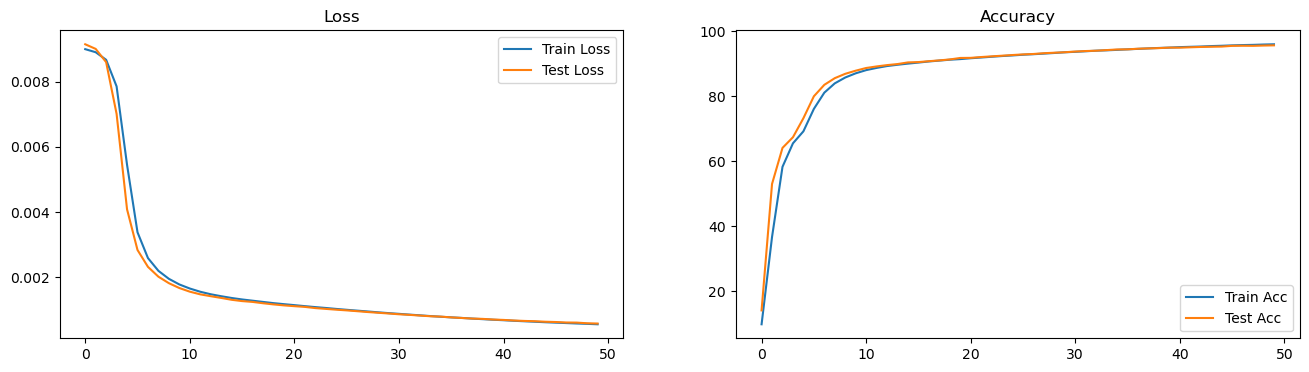

Best Metric
Train Loss: 0.0006, Train Acc: 95.9800
Test Loss: 0.0006, Test Acc: 95.6500


In [11]:
main('mnist', 'sgd', 'relu', 0)

### ***SGD + Leaky ReLU***

Epoch 1/50
Train Loss: 0.0090, Train Acc: 16.4333
Test Loss: 0.0091, Test Acc: 23.6200



Epoch 2/50
Train Loss: 0.0089, Train Acc: 25.4300
Test Loss: 0.0090, Test Acc: 27.2400



Epoch 3/50
Train Loss: 0.0086, Train Acc: 30.1600
Test Loss: 0.0085, Test Acc: 30.0000



Epoch 4/50
Train Loss: 0.0076, Train Acc: 34.7900
Test Loss: 0.0070, Test Acc: 48.6400



Epoch 5/50
Train Loss: 0.0057, Train Acc: 61.6817
Test Loss: 0.0046, Test Acc: 69.4800



Epoch 6/50
Train Loss: 0.0037, Train Acc: 73.8733
Test Loss: 0.0031, Test Acc: 78.0500



Epoch 7/50
Train Loss: 0.0028, Train Acc: 79.8067
Test Loss: 0.0025, Test Acc: 82.1400



Epoch 8/50
Train Loss: 0.0023, Train Acc: 83.2150
Test Loss: 0.0021, Test Acc: 84.7900



Epoch 9/50
Train Loss: 0.0020, Train Acc: 85.3283
Test Loss: 0.0019, Test Acc: 86.4500



Epoch 10/50
Train Loss: 0.0018, Train Acc: 86.7750
Test Loss: 0.0017, Test Acc: 87.1900



Epoch 11/50
Train Loss: 0.0017, Train Acc: 87.7683
Test Loss: 0.0016, Test Acc: 88.0100



Epoch 12/50
Train Loss: 0.0016, Train Acc: 88.4783
Test Loss: 0.0015, Test Acc: 88.8000



Epoch 13/50
Train Loss: 0.0015, Train Acc: 89.0433
Test Loss: 0.0014, Test Acc: 89.1500



Epoch 14/50
Train Loss: 0.0014, Train Acc: 89.5183
Test Loss: 0.0014, Test Acc: 89.6500



Epoch 15/50
Train Loss: 0.0014, Train Acc: 89.8400
Test Loss: 0.0013, Test Acc: 90.1200



Epoch 16/50
Train Loss: 0.0013, Train Acc: 90.2417
Test Loss: 0.0013, Test Acc: 90.5200



Epoch 17/50
Train Loss: 0.0013, Train Acc: 90.5633
Test Loss: 0.0012, Test Acc: 90.8300



Epoch 18/50
Train Loss: 0.0013, Train Acc: 90.8583
Test Loss: 0.0012, Test Acc: 91.0100



Epoch 19/50
Train Loss: 0.0012, Train Acc: 91.1050
Test Loss: 0.0012, Test Acc: 91.3200



Epoch 20/50
Train Loss: 0.0012, Train Acc: 91.3550
Test Loss: 0.0011, Test Acc: 91.4700



Epoch 21/50
Train Loss: 0.0011, Train Acc: 91.6533
Test Loss: 0.0011, Test Acc: 91.7200



Epoch 22/50
Train Loss: 0.0011, Train Acc: 91.8517
Test Loss: 0.0011, Test Acc: 92.1300



Epoch 23/50
Train Loss: 0.0011, Train Acc: 92.0867
Test Loss: 0.0011, Test Acc: 92.2600



Epoch 24/50
Train Loss: 0.0011, Train Acc: 92.2900
Test Loss: 0.0010, Test Acc: 92.5700



Epoch 25/50
Train Loss: 0.0010, Train Acc: 92.4783
Test Loss: 0.0010, Test Acc: 92.5900



Epoch 26/50
Train Loss: 0.0010, Train Acc: 92.7100
Test Loss: 0.0010, Test Acc: 92.7800



Epoch 27/50
Train Loss: 0.0010, Train Acc: 92.9167
Test Loss: 0.0010, Test Acc: 93.0900



Epoch 28/50
Train Loss: 0.0009, Train Acc: 93.1200
Test Loss: 0.0009, Test Acc: 93.2500



Epoch 29/50
Train Loss: 0.0009, Train Acc: 93.2817
Test Loss: 0.0009, Test Acc: 93.3200



Epoch 30/50
Train Loss: 0.0009, Train Acc: 93.4433
Test Loss: 0.0009, Test Acc: 93.4100



Epoch 31/50
Train Loss: 0.0009, Train Acc: 93.6100
Test Loss: 0.0009, Test Acc: 93.6000



Epoch 32/50
Train Loss: 0.0009, Train Acc: 93.8000
Test Loss: 0.0008, Test Acc: 93.8100



Epoch 33/50
Train Loss: 0.0008, Train Acc: 93.9633
Test Loss: 0.0008, Test Acc: 93.9400



Epoch 34/50
Train Loss: 0.0008, Train Acc: 94.0850
Test Loss: 0.0008, Test Acc: 94.0400



Epoch 35/50
Train Loss: 0.0008, Train Acc: 94.2033
Test Loss: 0.0008, Test Acc: 94.2300



Epoch 36/50
Train Loss: 0.0008, Train Acc: 94.3767
Test Loss: 0.0008, Test Acc: 94.2800



Epoch 37/50
Train Loss: 0.0008, Train Acc: 94.4550
Test Loss: 0.0008, Test Acc: 94.6200



Epoch 38/50
Train Loss: 0.0007, Train Acc: 94.6383
Test Loss: 0.0007, Test Acc: 94.5000



Epoch 39/50
Train Loss: 0.0007, Train Acc: 94.7633
Test Loss: 0.0007, Test Acc: 94.7500



Epoch 40/50
Train Loss: 0.0007, Train Acc: 94.8933
Test Loss: 0.0007, Test Acc: 94.8200



Epoch 41/50
Train Loss: 0.0007, Train Acc: 95.0233
Test Loss: 0.0007, Test Acc: 94.8900



Epoch 42/50
Train Loss: 0.0007, Train Acc: 95.1000
Test Loss: 0.0007, Test Acc: 94.9400



Epoch 43/50
Train Loss: 0.0007, Train Acc: 95.2100
Test Loss: 0.0007, Test Acc: 95.0300



Epoch 44/50
Train Loss: 0.0006, Train Acc: 95.3050
Test Loss: 0.0007, Test Acc: 95.1000



Epoch 45/50
Train Loss: 0.0006, Train Acc: 95.4000
Test Loss: 0.0006, Test Acc: 95.1300



Epoch 46/50
Train Loss: 0.0006, Train Acc: 95.4817
Test Loss: 0.0006, Test Acc: 95.2700



Epoch 47/50
Train Loss: 0.0006, Train Acc: 95.5767
Test Loss: 0.0006, Test Acc: 95.2600



Epoch 48/50
Train Loss: 0.0006, Train Acc: 95.6633
Test Loss: 0.0006, Test Acc: 95.4200



Epoch 49/50
Train Loss: 0.0006, Train Acc: 95.7417
Test Loss: 0.0006, Test Acc: 95.3800



Epoch 50/50
Train Loss: 0.0006, Train Acc: 95.8250
Test Loss: 0.0006, Test Acc: 95.5700



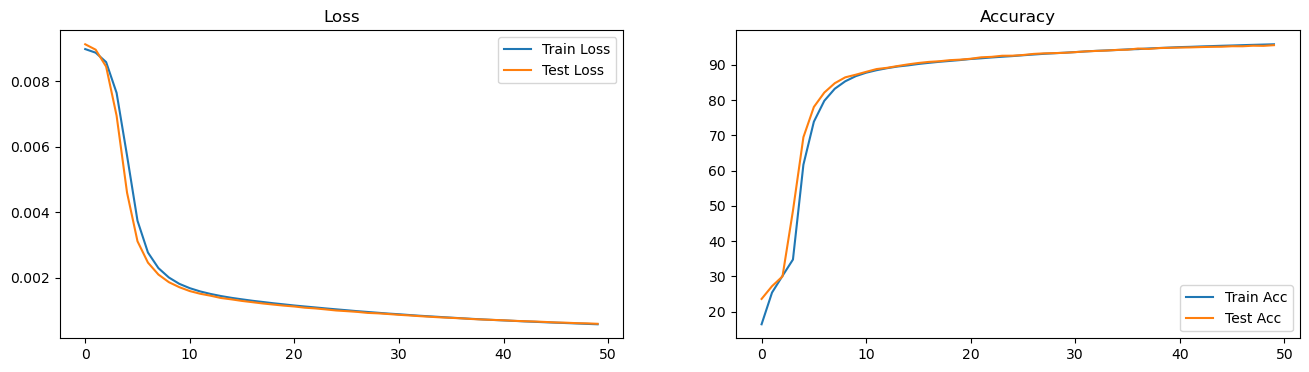

Best Metric
Train Loss: 0.0006, Train Acc: 95.8250
Test Loss: 0.0006, Test Acc: 95.5700


In [12]:
main('mnist', 'sgd', 'leaky_relu', 0)

### ***SGD + Sigmoid***

Epoch 1/50
Train Loss: 0.0090, Train Acc: 11.0267
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 2/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 3/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 4/50
Train Loss: 0.0090, Train Acc: 11.2967
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 5/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 6/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 7/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 8/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 9/50
Train Loss: 0.0090, Train Acc: 11.2033
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 10/50
Train Loss: 0.0090, Train Acc: 11.2333
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 11/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 12/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 13/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 14/50
Train Loss: 0.0090, Train Acc: 11.3317
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 15/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 16/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 17/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 18/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 19/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 20/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 21/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 22/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 23/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 24/50
Train Loss: 0.0090, Train Acc: 11.3583
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 25/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 26/50
Train Loss: 0.0090, Train Acc: 11.3083
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 27/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 28/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 29/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 30/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 31/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 32/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 33/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 34/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 35/50
Train Loss: 0.0090, Train Acc: 11.3917
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 36/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 37/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 38/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 39/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 40/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 41/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 42/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 43/50
Train Loss: 0.0090, Train Acc: 11.3483
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 44/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 45/50
Train Loss: 0.0090, Train Acc: 11.4200
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 46/50
Train Loss: 0.0090, Train Acc: 11.5700
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 47/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 48/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 49/50
Train Loss: 0.0090, Train Acc: 11.2367
Test Loss: 0.0092, Test Acc: 11.3500



Epoch 50/50
Train Loss: 0.0090, Train Acc: 11.2383
Test Loss: 0.0092, Test Acc: 11.3500



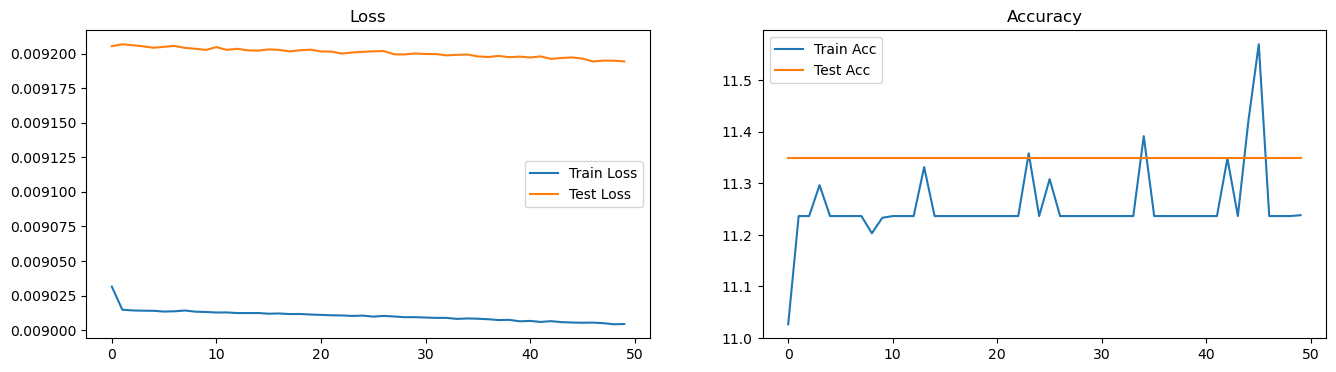

Best Metric
Train Loss: 0.0090, Train Acc: 11.0267
Test Loss: 0.0092, Test Acc: 11.3500


In [13]:
main('mnist', 'sgd', 'sigmoid', 0)

### ***Adam + ReLU***

Epoch 1/50
Train Loss: 0.0016, Train Acc: 88.7100
Test Loss: 0.0007, Test Acc: 95.0000



Epoch 2/50
Train Loss: 0.0005, Train Acc: 95.9667
Test Loss: 0.0004, Test Acc: 96.9100



Epoch 3/50
Train Loss: 0.0003, Train Acc: 97.4017
Test Loss: 0.0004, Test Acc: 97.1100



Epoch 4/50
Train Loss: 0.0002, Train Acc: 98.0583
Test Loss: 0.0003, Test Acc: 97.5900



Epoch 5/50
Train Loss: 0.0002, Train Acc: 98.5717
Test Loss: 0.0003, Test Acc: 97.7800



Epoch 6/50
Train Loss: 0.0001, Train Acc: 98.9350
Test Loss: 0.0003, Test Acc: 98.0600



Epoch 7/50
Train Loss: 0.0001, Train Acc: 99.2700
Test Loss: 0.0003, Test Acc: 98.0200



Epoch 8/50
Train Loss: 0.0001, Train Acc: 99.3633
Test Loss: 0.0003, Test Acc: 98.0600



Epoch 9/50
Train Loss: 0.0001, Train Acc: 99.4433
Test Loss: 0.0003, Test Acc: 97.7700



Epoch 10/50
Train Loss: 0.0001, Train Acc: 99.4700
Test Loss: 0.0003, Test Acc: 97.6900



Epoch 11/50
Train Loss: 0.0001, Train Acc: 99.5617
Test Loss: 0.0003, Test Acc: 98.0900



Epoch 12/50
Train Loss: 0.0000, Train Acc: 99.6183
Test Loss: 0.0003, Test Acc: 98.1100



Epoch 13/50
Train Loss: 0.0000, Train Acc: 99.7383
Test Loss: 0.0003, Test Acc: 98.3900



Epoch 14/50
Train Loss: 0.0000, Train Acc: 99.6317
Test Loss: 0.0004, Test Acc: 97.7100



Epoch 15/50
Train Loss: 0.0000, Train Acc: 99.6833
Test Loss: 0.0003, Test Acc: 98.3900



Epoch 16/50
Train Loss: 0.0000, Train Acc: 99.6367
Test Loss: 0.0004, Test Acc: 97.9400



Epoch 17/50
Train Loss: 0.0000, Train Acc: 99.6700
Test Loss: 0.0004, Test Acc: 98.1400



Epoch 18/50
Train Loss: 0.0000, Train Acc: 99.7450
Test Loss: 0.0004, Test Acc: 97.9400



Epoch 19/50
Train Loss: 0.0000, Train Acc: 99.8733
Test Loss: 0.0003, Test Acc: 98.2600



Epoch 20/50
Train Loss: 0.0000, Train Acc: 99.7467
Test Loss: 0.0004, Test Acc: 98.1500



Epoch 21/50
Train Loss: 0.0000, Train Acc: 99.6367
Test Loss: 0.0003, Test Acc: 98.0400



Epoch 22/50
Train Loss: 0.0000, Train Acc: 99.7667
Test Loss: 0.0003, Test Acc: 98.3200



Epoch 23/50
Train Loss: 0.0000, Train Acc: 99.8733
Test Loss: 0.0004, Test Acc: 98.1900



Epoch 24/50
Train Loss: 0.0000, Train Acc: 99.7983
Test Loss: 0.0003, Test Acc: 98.4300



Epoch 25/50
Train Loss: 0.0000, Train Acc: 99.7783
Test Loss: 0.0004, Test Acc: 97.8600



Epoch 26/50
Train Loss: 0.0000, Train Acc: 99.7167
Test Loss: 0.0004, Test Acc: 98.0400



Epoch 27/50
Train Loss: 0.0000, Train Acc: 99.8267
Test Loss: 0.0005, Test Acc: 97.9500



Epoch 28/50
Train Loss: 0.0000, Train Acc: 99.9250
Test Loss: 0.0004, Test Acc: 98.4700



Epoch 29/50
Train Loss: 0.0000, Train Acc: 99.9933
Test Loss: 0.0004, Test Acc: 98.3700



Epoch 30/50
Train Loss: 0.0000, Train Acc: 99.8267
Test Loss: 0.0005, Test Acc: 97.6400



Epoch 31/50
Train Loss: 0.0000, Train Acc: 99.6550
Test Loss: 0.0004, Test Acc: 98.2400



Epoch 32/50
Train Loss: 0.0000, Train Acc: 99.9000
Test Loss: 0.0003, Test Acc: 98.4000



Epoch 33/50
Train Loss: 0.0000, Train Acc: 99.9467
Test Loss: 0.0004, Test Acc: 98.3000



Epoch 34/50
Train Loss: 0.0000, Train Acc: 99.7667
Test Loss: 0.0004, Test Acc: 97.8600



Epoch 35/50
Train Loss: 0.0000, Train Acc: 99.8417
Test Loss: 0.0004, Test Acc: 97.9000



Epoch 36/50
Train Loss: 0.0000, Train Acc: 99.8933
Test Loss: 0.0004, Test Acc: 98.3800



Epoch 37/50
Train Loss: 0.0000, Train Acc: 99.8650
Test Loss: 0.0004, Test Acc: 98.1000



Epoch 38/50
Train Loss: 0.0000, Train Acc: 99.9333
Test Loss: 0.0004, Test Acc: 98.3200



Epoch 39/50
Train Loss: 0.0000, Train Acc: 99.8017
Test Loss: 0.0004, Test Acc: 97.9800



Epoch 40/50
Train Loss: 0.0000, Train Acc: 99.7683
Test Loss: 0.0004, Test Acc: 97.9400



Epoch 41/50
Train Loss: 0.0000, Train Acc: 99.9183
Test Loss: 0.0004, Test Acc: 98.3200



Epoch 42/50
Train Loss: 0.0000, Train Acc: 99.9217
Test Loss: 0.0004, Test Acc: 98.3400



Epoch 43/50
Train Loss: 0.0000, Train Acc: 99.9467
Test Loss: 0.0004, Test Acc: 98.3000



Epoch 44/50
Train Loss: 0.0000, Train Acc: 99.7917
Test Loss: 0.0004, Test Acc: 98.3700



Epoch 45/50
Train Loss: 0.0000, Train Acc: 99.8950
Test Loss: 0.0004, Test Acc: 98.3400



Epoch 46/50
Train Loss: 0.0000, Train Acc: 99.9650
Test Loss: 0.0004, Test Acc: 98.3700



Epoch 47/50
Train Loss: 0.0000, Train Acc: 99.9917
Test Loss: 0.0004, Test Acc: 98.4200



Epoch 48/50
Train Loss: 0.0000, Train Acc: 100.0000
Test Loss: 0.0004, Test Acc: 98.4500



Epoch 49/50
Train Loss: 0.0000, Train Acc: 100.0000
Test Loss: 0.0004, Test Acc: 98.4600



Epoch 50/50
Train Loss: 0.0000, Train Acc: 100.0000
Test Loss: 0.0004, Test Acc: 98.4700



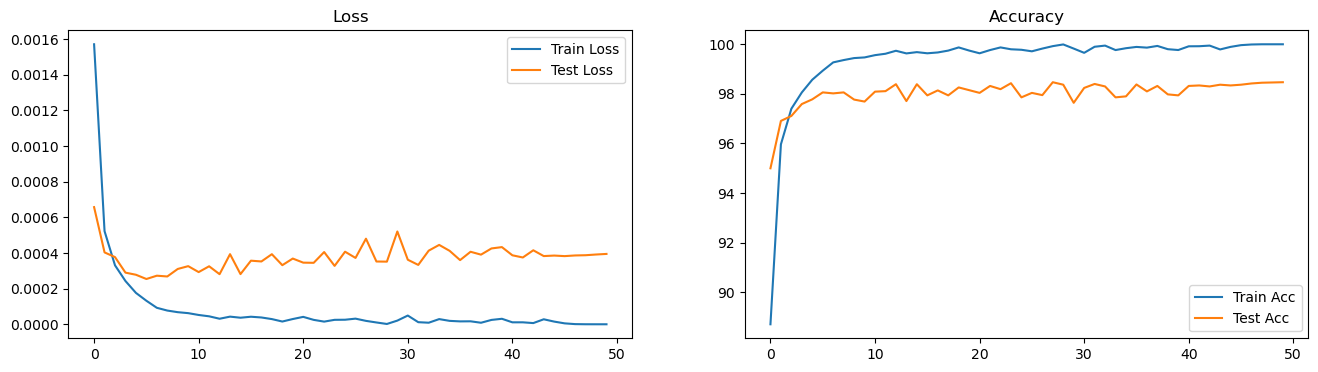

Best Metric
Train Loss: 0.0000, Train Acc: 99.9250
Test Loss: 0.0004, Test Acc: 98.4700


In [14]:
main('mnist', 'adam', 'relu', 0)

### ***Adam + ReLU + Dropout***

Epoch 1/50
Train Loss: 0.0018, Train Acc: 85.5850
Test Loss: 0.0007, Test Acc: 94.7900



Epoch 2/50
Train Loss: 0.0006, Train Acc: 95.1133
Test Loss: 0.0004, Test Acc: 96.8900



Epoch 3/50
Train Loss: 0.0004, Train Acc: 96.6233
Test Loss: 0.0004, Test Acc: 97.1600



Epoch 4/50
Train Loss: 0.0004, Train Acc: 97.2417
Test Loss: 0.0003, Test Acc: 97.9100



Epoch 5/50
Train Loss: 0.0003, Train Acc: 97.7517
Test Loss: 0.0003, Test Acc: 97.9500



Epoch 6/50
Train Loss: 0.0003, Train Acc: 97.8667
Test Loss: 0.0003, Test Acc: 98.1300



Epoch 7/50
Train Loss: 0.0002, Train Acc: 98.3267
Test Loss: 0.0002, Test Acc: 98.1500



Epoch 8/50
Train Loss: 0.0002, Train Acc: 98.3500
Test Loss: 0.0003, Test Acc: 97.8700



Epoch 9/50
Train Loss: 0.0002, Train Acc: 98.5983
Test Loss: 0.0003, Test Acc: 97.9800



Epoch 10/50
Train Loss: 0.0002, Train Acc: 98.6450
Test Loss: 0.0002, Test Acc: 98.3300



Epoch 11/50
Train Loss: 0.0002, Train Acc: 98.7633
Test Loss: 0.0003, Test Acc: 98.3400



Epoch 12/50
Train Loss: 0.0001, Train Acc: 98.8667
Test Loss: 0.0002, Test Acc: 98.3400



Epoch 13/50
Train Loss: 0.0001, Train Acc: 98.9833
Test Loss: 0.0003, Test Acc: 98.2600



Epoch 14/50
Train Loss: 0.0001, Train Acc: 99.0650
Test Loss: 0.0003, Test Acc: 98.2700



Epoch 15/50
Train Loss: 0.0001, Train Acc: 99.0433
Test Loss: 0.0003, Test Acc: 98.2700



Epoch 16/50
Train Loss: 0.0001, Train Acc: 99.1150
Test Loss: 0.0002, Test Acc: 98.3800



Epoch 17/50
Train Loss: 0.0001, Train Acc: 99.1150
Test Loss: 0.0002, Test Acc: 98.3200



Epoch 18/50
Train Loss: 0.0001, Train Acc: 99.2417
Test Loss: 0.0002, Test Acc: 98.4800



Epoch 19/50
Train Loss: 0.0001, Train Acc: 99.1567
Test Loss: 0.0002, Test Acc: 98.3200



Epoch 20/50
Train Loss: 0.0001, Train Acc: 99.3267
Test Loss: 0.0003, Test Acc: 98.3800



Epoch 21/50
Train Loss: 0.0001, Train Acc: 99.3933
Test Loss: 0.0003, Test Acc: 98.2700



Epoch 22/50
Train Loss: 0.0001, Train Acc: 99.3467
Test Loss: 0.0003, Test Acc: 98.4900



Epoch 23/50
Train Loss: 0.0001, Train Acc: 99.4267
Test Loss: 0.0002, Test Acc: 98.4400



Epoch 24/50
Train Loss: 0.0001, Train Acc: 99.3333
Test Loss: 0.0002, Test Acc: 98.4600



Epoch 25/50
Train Loss: 0.0001, Train Acc: 99.3517
Test Loss: 0.0003, Test Acc: 98.4500



Epoch 26/50
Train Loss: 0.0001, Train Acc: 99.3783
Test Loss: 0.0003, Test Acc: 98.4600



Epoch 27/50
Train Loss: 0.0001, Train Acc: 99.4683
Test Loss: 0.0003, Test Acc: 98.4900



Epoch 28/50
Train Loss: 0.0001, Train Acc: 99.4150
Test Loss: 0.0003, Test Acc: 98.3600



Epoch 29/50
Train Loss: 0.0001, Train Acc: 99.5067
Test Loss: 0.0003, Test Acc: 98.4700



Epoch 30/50
Train Loss: 0.0001, Train Acc: 99.4100
Test Loss: 0.0002, Test Acc: 98.4900



Epoch 31/50
Train Loss: 0.0001, Train Acc: 99.4683
Test Loss: 0.0003, Test Acc: 98.4100



Epoch 32/50
Train Loss: 0.0001, Train Acc: 99.5117
Test Loss: 0.0003, Test Acc: 98.3900



Epoch 33/50
Train Loss: 0.0001, Train Acc: 99.5300
Test Loss: 0.0003, Test Acc: 98.4500



Epoch 34/50
Train Loss: 0.0001, Train Acc: 99.5667
Test Loss: 0.0003, Test Acc: 98.4300



Epoch 35/50
Train Loss: 0.0001, Train Acc: 99.5100
Test Loss: 0.0003, Test Acc: 98.3300



Epoch 36/50
Train Loss: 0.0001, Train Acc: 99.5433
Test Loss: 0.0003, Test Acc: 98.4200



Epoch 37/50
Train Loss: 0.0000, Train Acc: 99.6067
Test Loss: 0.0003, Test Acc: 98.4600



Epoch 38/50
Train Loss: 0.0001, Train Acc: 99.5467
Test Loss: 0.0003, Test Acc: 98.3400



Epoch 39/50
Train Loss: 0.0001, Train Acc: 99.5133
Test Loss: 0.0003, Test Acc: 98.3400



Epoch 40/50
Train Loss: 0.0001, Train Acc: 99.5500
Test Loss: 0.0003, Test Acc: 98.2700



Epoch 41/50
Train Loss: 0.0000, Train Acc: 99.6150
Test Loss: 0.0003, Test Acc: 98.4100



Epoch 42/50
Train Loss: 0.0001, Train Acc: 99.5367
Test Loss: 0.0003, Test Acc: 98.4200



Epoch 43/50
Train Loss: 0.0001, Train Acc: 99.5767
Test Loss: 0.0003, Test Acc: 98.4700



Epoch 44/50
Train Loss: 0.0000, Train Acc: 99.5933
Test Loss: 0.0003, Test Acc: 98.5300



Epoch 45/50
Train Loss: 0.0001, Train Acc: 99.5817
Test Loss: 0.0003, Test Acc: 98.5300



Epoch 46/50
Train Loss: 0.0001, Train Acc: 99.5900
Test Loss: 0.0003, Test Acc: 98.5000



Epoch 47/50
Train Loss: 0.0001, Train Acc: 99.5767
Test Loss: 0.0003, Test Acc: 98.3100



Epoch 48/50
Train Loss: 0.0000, Train Acc: 99.6250
Test Loss: 0.0003, Test Acc: 98.3200



Epoch 49/50
Train Loss: 0.0000, Train Acc: 99.6467
Test Loss: 0.0003, Test Acc: 98.5000



Epoch 50/50
Train Loss: 0.0001, Train Acc: 99.6117
Test Loss: 0.0003, Test Acc: 98.5500



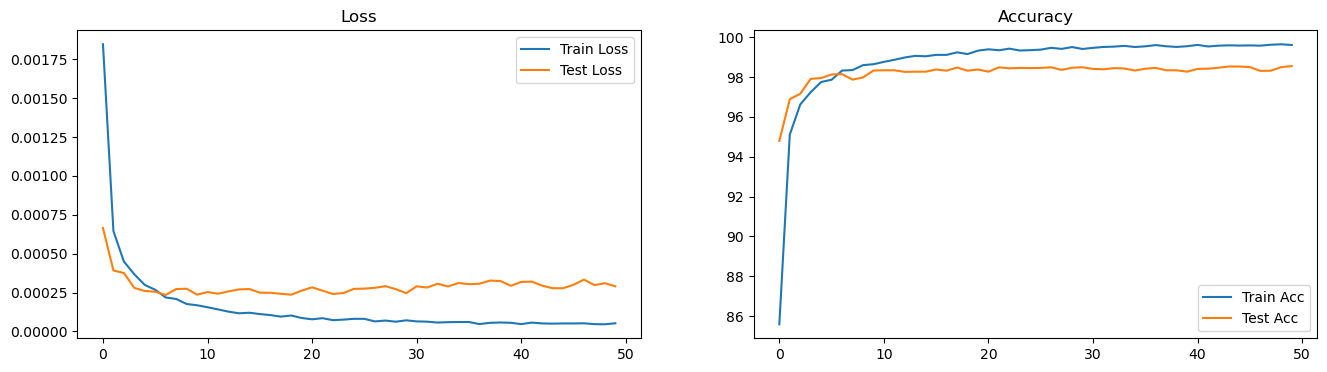

Best Metric
Train Loss: 0.0001, Train Acc: 99.6117
Test Loss: 0.0003, Test Acc: 98.5500


In [15]:
main('mnist', 'adam', 'relu', 0.3)

# ***CIFAR 10***

### ***SGD + ReLU***

Files already downloaded and verified


Files already downloaded and verified


Epoch 1/50
Train Loss: 0.0090, Train Acc: 11.2420
Test Loss: 0.0091, Test Acc: 15.5800



Epoch 2/50
Train Loss: 0.0089, Train Acc: 20.9480
Test Loss: 0.0090, Test Acc: 24.2000



Epoch 3/50
Train Loss: 0.0086, Train Acc: 24.7240
Test Loss: 0.0086, Test Acc: 25.7200



Epoch 4/50
Train Loss: 0.0082, Train Acc: 25.4760
Test Loss: 0.0082, Test Acc: 27.2800



Epoch 5/50
Train Loss: 0.0079, Train Acc: 27.8120
Test Loss: 0.0078, Test Acc: 29.1500



Epoch 6/50
Train Loss: 0.0076, Train Acc: 30.2500
Test Loss: 0.0076, Test Acc: 31.0800



Epoch 7/50
Train Loss: 0.0074, Train Acc: 32.2020
Test Loss: 0.0074, Test Acc: 32.9400



Epoch 8/50
Train Loss: 0.0072, Train Acc: 33.9680
Test Loss: 0.0073, Test Acc: 34.9000



Epoch 9/50
Train Loss: 0.0071, Train Acc: 35.4680
Test Loss: 0.0071, Test Acc: 36.2900



Epoch 10/50
Train Loss: 0.0070, Train Acc: 36.9680
Test Loss: 0.0070, Test Acc: 38.1600



Epoch 11/50
Train Loss: 0.0068, Train Acc: 38.1520
Test Loss: 0.0069, Test Acc: 39.3000



Epoch 12/50
Train Loss: 0.0067, Train Acc: 39.1400
Test Loss: 0.0068, Test Acc: 40.0200



Epoch 13/50
Train Loss: 0.0066, Train Acc: 40.2400
Test Loss: 0.0066, Test Acc: 41.0400



Epoch 14/50
Train Loss: 0.0065, Train Acc: 41.1700
Test Loss: 0.0066, Test Acc: 41.7500



Epoch 15/50
Train Loss: 0.0064, Train Acc: 42.0900
Test Loss: 0.0065, Test Acc: 42.5700



Epoch 16/50
Train Loss: 0.0063, Train Acc: 42.7280
Test Loss: 0.0064, Test Acc: 43.2100



Epoch 17/50
Train Loss: 0.0062, Train Acc: 43.5140
Test Loss: 0.0063, Test Acc: 44.0600



Epoch 18/50
Train Loss: 0.0061, Train Acc: 44.3460
Test Loss: 0.0063, Test Acc: 44.1800



Epoch 19/50
Train Loss: 0.0061, Train Acc: 44.9220
Test Loss: 0.0062, Test Acc: 45.2100



Epoch 20/50
Train Loss: 0.0060, Train Acc: 45.7120
Test Loss: 0.0061, Test Acc: 46.0900



Epoch 21/50
Train Loss: 0.0059, Train Acc: 46.4120
Test Loss: 0.0061, Test Acc: 46.5200



Epoch 22/50
Train Loss: 0.0058, Train Acc: 47.0320
Test Loss: 0.0060, Test Acc: 47.1100



Epoch 23/50
Train Loss: 0.0058, Train Acc: 47.8500
Test Loss: 0.0060, Test Acc: 47.7000



Epoch 24/50
Train Loss: 0.0057, Train Acc: 48.5200
Test Loss: 0.0059, Test Acc: 48.0100



Epoch 25/50
Train Loss: 0.0056, Train Acc: 49.1200
Test Loss: 0.0059, Test Acc: 48.8900



Epoch 26/50
Train Loss: 0.0055, Train Acc: 49.7560
Test Loss: 0.0058, Test Acc: 48.6500



Epoch 27/50
Train Loss: 0.0055, Train Acc: 50.4080
Test Loss: 0.0058, Test Acc: 49.4200



Epoch 28/50
Train Loss: 0.0054, Train Acc: 50.9980
Test Loss: 0.0057, Test Acc: 49.5500



Epoch 29/50
Train Loss: 0.0053, Train Acc: 51.7540
Test Loss: 0.0057, Test Acc: 49.7600



Epoch 30/50
Train Loss: 0.0053, Train Acc: 52.4300
Test Loss: 0.0056, Test Acc: 50.1200



Epoch 31/50
Train Loss: 0.0052, Train Acc: 52.8700
Test Loss: 0.0056, Test Acc: 50.5700



Epoch 32/50
Train Loss: 0.0052, Train Acc: 53.5160
Test Loss: 0.0056, Test Acc: 50.6500



Epoch 33/50
Train Loss: 0.0051, Train Acc: 54.1720
Test Loss: 0.0055, Test Acc: 51.1200



Epoch 34/50
Train Loss: 0.0050, Train Acc: 54.8000
Test Loss: 0.0055, Test Acc: 51.4100



Epoch 35/50
Train Loss: 0.0050, Train Acc: 55.3640
Test Loss: 0.0055, Test Acc: 51.5800



Epoch 36/50
Train Loss: 0.0049, Train Acc: 55.8020
Test Loss: 0.0055, Test Acc: 52.0500



Epoch 37/50
Train Loss: 0.0048, Train Acc: 56.4920
Test Loss: 0.0054, Test Acc: 52.3300



Epoch 38/50
Train Loss: 0.0048, Train Acc: 56.9580
Test Loss: 0.0054, Test Acc: 52.4600



Epoch 39/50
Train Loss: 0.0047, Train Acc: 57.6520
Test Loss: 0.0054, Test Acc: 52.7000



Epoch 40/50
Train Loss: 0.0047, Train Acc: 57.9940
Test Loss: 0.0054, Test Acc: 52.5900



Epoch 41/50
Train Loss: 0.0046, Train Acc: 58.5620
Test Loss: 0.0054, Test Acc: 52.9600



Epoch 42/50
Train Loss: 0.0045, Train Acc: 59.0260
Test Loss: 0.0053, Test Acc: 53.2100



Epoch 43/50
Train Loss: 0.0045, Train Acc: 59.7400
Test Loss: 0.0053, Test Acc: 53.2100



Epoch 44/50
Train Loss: 0.0044, Train Acc: 60.2660
Test Loss: 0.0054, Test Acc: 52.9700



Epoch 45/50
Train Loss: 0.0044, Train Acc: 60.8020
Test Loss: 0.0054, Test Acc: 53.0100



Epoch 46/50
Train Loss: 0.0043, Train Acc: 61.3360
Test Loss: 0.0053, Test Acc: 53.3300



Epoch 47/50
Train Loss: 0.0042, Train Acc: 61.8580
Test Loss: 0.0053, Test Acc: 53.0300



Epoch 48/50
Train Loss: 0.0042, Train Acc: 62.3680
Test Loss: 0.0053, Test Acc: 53.1400



Epoch 49/50
Train Loss: 0.0041, Train Acc: 62.8620
Test Loss: 0.0053, Test Acc: 53.3300



Epoch 50/50
Train Loss: 0.0041, Train Acc: 63.5180
Test Loss: 0.0053, Test Acc: 53.4500



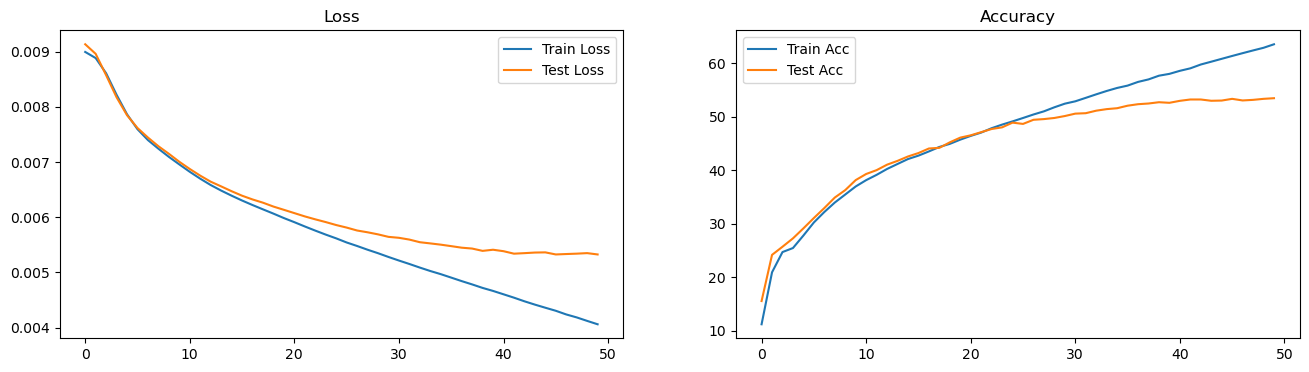

Best Metric
Train Loss: 0.0041, Train Acc: 63.5180
Test Loss: 0.0053, Test Acc: 53.4500


In [16]:
main('cifar10', 'sgd', 'relu', 0)

### ***SGD + Leaky ReLU***

Files already downloaded and verified


Files already downloaded and verified


Epoch 1/50
Train Loss: 0.0090, Train Acc: 13.6460
Test Loss: 0.0091, Test Acc: 18.9900



Epoch 2/50
Train Loss: 0.0088, Train Acc: 21.1640
Test Loss: 0.0089, Test Acc: 22.6000



Epoch 3/50
Train Loss: 0.0085, Train Acc: 23.0880
Test Loss: 0.0084, Test Acc: 24.7100



Epoch 4/50
Train Loss: 0.0081, Train Acc: 25.1800
Test Loss: 0.0081, Test Acc: 27.4700



Epoch 5/50
Train Loss: 0.0078, Train Acc: 28.1160
Test Loss: 0.0078, Test Acc: 29.8900



Epoch 6/50
Train Loss: 0.0076, Train Acc: 30.7800
Test Loss: 0.0076, Test Acc: 32.5100



Epoch 7/50
Train Loss: 0.0073, Train Acc: 33.0580
Test Loss: 0.0074, Test Acc: 34.0800



Epoch 8/50
Train Loss: 0.0072, Train Acc: 35.0460
Test Loss: 0.0072, Test Acc: 35.7100



Epoch 9/50
Train Loss: 0.0070, Train Acc: 36.1280
Test Loss: 0.0070, Test Acc: 37.0400



Epoch 10/50
Train Loss: 0.0068, Train Acc: 37.5120
Test Loss: 0.0069, Test Acc: 38.3100



Epoch 11/50
Train Loss: 0.0067, Train Acc: 38.8780
Test Loss: 0.0068, Test Acc: 39.2500



Epoch 12/50
Train Loss: 0.0066, Train Acc: 40.0000
Test Loss: 0.0067, Test Acc: 40.6200



Epoch 13/50
Train Loss: 0.0065, Train Acc: 41.0540
Test Loss: 0.0065, Test Acc: 41.7200



Epoch 14/50
Train Loss: 0.0064, Train Acc: 41.9980
Test Loss: 0.0065, Test Acc: 42.5200



Epoch 15/50
Train Loss: 0.0063, Train Acc: 42.8680
Test Loss: 0.0064, Test Acc: 43.5300



Epoch 16/50
Train Loss: 0.0062, Train Acc: 43.6560
Test Loss: 0.0063, Test Acc: 44.3400



Epoch 17/50
Train Loss: 0.0061, Train Acc: 44.5980
Test Loss: 0.0062, Test Acc: 44.8200



Epoch 18/50
Train Loss: 0.0060, Train Acc: 45.3700
Test Loss: 0.0062, Test Acc: 45.4200



Epoch 19/50
Train Loss: 0.0060, Train Acc: 46.1120
Test Loss: 0.0061, Test Acc: 46.1400



Epoch 20/50
Train Loss: 0.0059, Train Acc: 46.8040
Test Loss: 0.0060, Test Acc: 46.7400



Epoch 21/50
Train Loss: 0.0058, Train Acc: 47.6560
Test Loss: 0.0060, Test Acc: 47.2400



Epoch 22/50
Train Loss: 0.0057, Train Acc: 48.2820
Test Loss: 0.0059, Test Acc: 48.0200



Epoch 23/50
Train Loss: 0.0057, Train Acc: 48.8340
Test Loss: 0.0059, Test Acc: 48.1600



Epoch 24/50
Train Loss: 0.0056, Train Acc: 49.6620
Test Loss: 0.0058, Test Acc: 48.9400



Epoch 25/50
Train Loss: 0.0055, Train Acc: 50.3320
Test Loss: 0.0058, Test Acc: 49.3700



Epoch 26/50
Train Loss: 0.0054, Train Acc: 50.8780
Test Loss: 0.0057, Test Acc: 49.4700



Epoch 27/50
Train Loss: 0.0054, Train Acc: 51.6160
Test Loss: 0.0057, Test Acc: 49.9200



Epoch 28/50
Train Loss: 0.0053, Train Acc: 52.1500
Test Loss: 0.0057, Test Acc: 50.1700



Epoch 29/50
Train Loss: 0.0052, Train Acc: 52.8620
Test Loss: 0.0056, Test Acc: 50.0400



Epoch 30/50
Train Loss: 0.0052, Train Acc: 53.4420
Test Loss: 0.0056, Test Acc: 50.5500



Epoch 31/50
Train Loss: 0.0051, Train Acc: 54.0660
Test Loss: 0.0055, Test Acc: 50.8700



Epoch 32/50
Train Loss: 0.0051, Train Acc: 54.6160
Test Loss: 0.0055, Test Acc: 51.4800



Epoch 33/50
Train Loss: 0.0050, Train Acc: 55.2100
Test Loss: 0.0055, Test Acc: 51.7700



Epoch 34/50
Train Loss: 0.0049, Train Acc: 55.7560
Test Loss: 0.0055, Test Acc: 51.5700



Epoch 35/50
Train Loss: 0.0049, Train Acc: 56.3980
Test Loss: 0.0054, Test Acc: 52.3200



Epoch 36/50
Train Loss: 0.0048, Train Acc: 56.9000
Test Loss: 0.0054, Test Acc: 52.4900



Epoch 37/50
Train Loss: 0.0048, Train Acc: 57.4760
Test Loss: 0.0054, Test Acc: 52.5100



Epoch 38/50
Train Loss: 0.0047, Train Acc: 57.9560
Test Loss: 0.0054, Test Acc: 52.2600



Epoch 39/50
Train Loss: 0.0046, Train Acc: 58.4240
Test Loss: 0.0054, Test Acc: 52.6900



Epoch 40/50
Train Loss: 0.0046, Train Acc: 59.1320
Test Loss: 0.0054, Test Acc: 52.7100



Epoch 41/50
Train Loss: 0.0045, Train Acc: 59.6300
Test Loss: 0.0054, Test Acc: 52.9100



Epoch 42/50
Train Loss: 0.0045, Train Acc: 60.1760
Test Loss: 0.0053, Test Acc: 53.1100



Epoch 43/50
Train Loss: 0.0044, Train Acc: 60.6340
Test Loss: 0.0053, Test Acc: 53.0100



Epoch 44/50
Train Loss: 0.0043, Train Acc: 61.2040
Test Loss: 0.0054, Test Acc: 53.0100



Epoch 45/50
Train Loss: 0.0043, Train Acc: 61.7560
Test Loss: 0.0054, Test Acc: 52.9800



Epoch 46/50
Train Loss: 0.0042, Train Acc: 62.3120
Test Loss: 0.0053, Test Acc: 53.4800



Epoch 47/50
Train Loss: 0.0042, Train Acc: 62.6820
Test Loss: 0.0054, Test Acc: 53.0900



Epoch 48/50
Train Loss: 0.0041, Train Acc: 63.4160
Test Loss: 0.0053, Test Acc: 53.4100



Epoch 49/50
Train Loss: 0.0040, Train Acc: 63.8220
Test Loss: 0.0053, Test Acc: 53.7600



Epoch 50/50
Train Loss: 0.0040, Train Acc: 64.4320
Test Loss: 0.0053, Test Acc: 53.4500



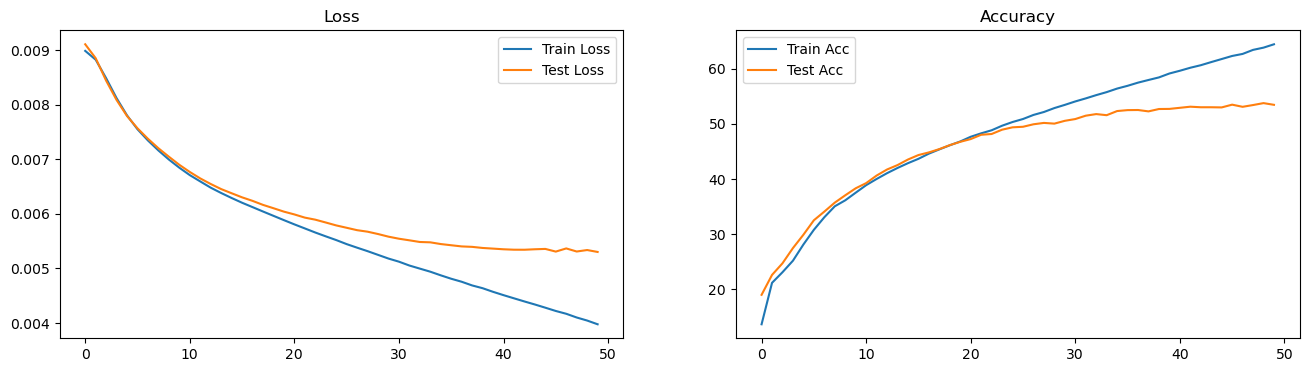

Best Metric
Train Loss: 0.0040, Train Acc: 63.8220
Test Loss: 0.0053, Test Acc: 53.7600


In [17]:
main('cifar10', 'sgd', 'leaky_relu', 0)

### ***SGD + Sigmoid***

Files already downloaded and verified


Files already downloaded and verified


Epoch 1/50
Train Loss: 0.0090, Train Acc: 9.8520
Test Loss: 0.0092, Test Acc: 10.0000



Epoch 2/50
Train Loss: 0.0090, Train Acc: 10.3360
Test Loss: 0.0092, Test Acc: 10.0000



Epoch 3/50
Train Loss: 0.0090, Train Acc: 10.4160
Test Loss: 0.0092, Test Acc: 10.0000



Epoch 4/50
Train Loss: 0.0090, Train Acc: 10.4280
Test Loss: 0.0092, Test Acc: 10.0000



Epoch 5/50
Train Loss: 0.0090, Train Acc: 10.2120
Test Loss: 0.0092, Test Acc: 10.7600



Epoch 6/50
Train Loss: 0.0090, Train Acc: 10.3600
Test Loss: 0.0092, Test Acc: 10.0000



Epoch 7/50
Train Loss: 0.0090, Train Acc: 10.4880
Test Loss: 0.0092, Test Acc: 13.3200



Epoch 8/50
Train Loss: 0.0090, Train Acc: 10.3980
Test Loss: 0.0092, Test Acc: 10.0000



Epoch 9/50
Train Loss: 0.0090, Train Acc: 11.3660
Test Loss: 0.0092, Test Acc: 12.2200



Epoch 10/50
Train Loss: 0.0090, Train Acc: 11.1580
Test Loss: 0.0092, Test Acc: 10.0000



Epoch 11/50
Train Loss: 0.0090, Train Acc: 11.5200
Test Loss: 0.0092, Test Acc: 10.6000



Epoch 12/50
Train Loss: 0.0090, Train Acc: 10.6940
Test Loss: 0.0092, Test Acc: 10.0600



Epoch 13/50
Train Loss: 0.0090, Train Acc: 11.9620
Test Loss: 0.0092, Test Acc: 15.3300



Epoch 14/50
Train Loss: 0.0090, Train Acc: 10.8180
Test Loss: 0.0092, Test Acc: 10.0000



Epoch 15/50
Train Loss: 0.0090, Train Acc: 11.1360
Test Loss: 0.0092, Test Acc: 15.4200



Epoch 16/50
Train Loss: 0.0090, Train Acc: 11.4620
Test Loss: 0.0092, Test Acc: 10.0000



Epoch 17/50
Train Loss: 0.0090, Train Acc: 11.0880
Test Loss: 0.0092, Test Acc: 10.0000



Epoch 18/50
Train Loss: 0.0090, Train Acc: 12.1500
Test Loss: 0.0092, Test Acc: 12.3900



Epoch 19/50
Train Loss: 0.0090, Train Acc: 11.8180
Test Loss: 0.0092, Test Acc: 13.7100



Epoch 20/50
Train Loss: 0.0090, Train Acc: 13.3200
Test Loss: 0.0092, Test Acc: 15.6100



Epoch 21/50
Train Loss: 0.0090, Train Acc: 12.2860
Test Loss: 0.0092, Test Acc: 11.0100



Epoch 22/50
Train Loss: 0.0090, Train Acc: 12.8540
Test Loss: 0.0092, Test Acc: 17.5700



Epoch 23/50
Train Loss: 0.0090, Train Acc: 13.2720
Test Loss: 0.0092, Test Acc: 15.3700



Epoch 24/50
Train Loss: 0.0090, Train Acc: 12.6220
Test Loss: 0.0092, Test Acc: 12.0700



Epoch 25/50
Train Loss: 0.0090, Train Acc: 13.0960
Test Loss: 0.0092, Test Acc: 10.2300



Epoch 26/50
Train Loss: 0.0090, Train Acc: 14.5640
Test Loss: 0.0092, Test Acc: 13.2700



Epoch 27/50
Train Loss: 0.0090, Train Acc: 14.3180
Test Loss: 0.0092, Test Acc: 15.4300



Epoch 28/50
Train Loss: 0.0090, Train Acc: 14.1920
Test Loss: 0.0092, Test Acc: 14.5300



Epoch 29/50
Train Loss: 0.0090, Train Acc: 14.7120
Test Loss: 0.0092, Test Acc: 13.6800



Epoch 30/50
Train Loss: 0.0090, Train Acc: 15.3220
Test Loss: 0.0092, Test Acc: 14.7500



Epoch 31/50
Train Loss: 0.0090, Train Acc: 16.0160
Test Loss: 0.0092, Test Acc: 12.3800



Epoch 32/50
Train Loss: 0.0090, Train Acc: 15.3840
Test Loss: 0.0092, Test Acc: 16.3900



Epoch 33/50
Train Loss: 0.0090, Train Acc: 15.9300
Test Loss: 0.0092, Test Acc: 13.2400



Epoch 34/50
Train Loss: 0.0090, Train Acc: 15.7820
Test Loss: 0.0092, Test Acc: 18.5600



Epoch 35/50
Train Loss: 0.0090, Train Acc: 16.6280
Test Loss: 0.0092, Test Acc: 16.2500



Epoch 36/50
Train Loss: 0.0090, Train Acc: 16.7140
Test Loss: 0.0091, Test Acc: 18.9600



Epoch 37/50
Train Loss: 0.0090, Train Acc: 16.3720
Test Loss: 0.0091, Test Acc: 19.0600



Epoch 38/50
Train Loss: 0.0089, Train Acc: 17.3200
Test Loss: 0.0091, Test Acc: 18.8600



Epoch 39/50
Train Loss: 0.0089, Train Acc: 17.3840
Test Loss: 0.0091, Test Acc: 17.9100



Epoch 40/50
Train Loss: 0.0089, Train Acc: 16.9800
Test Loss: 0.0091, Test Acc: 17.7400



Epoch 41/50
Train Loss: 0.0089, Train Acc: 17.3640
Test Loss: 0.0091, Test Acc: 17.6100



Epoch 42/50
Train Loss: 0.0089, Train Acc: 17.4960
Test Loss: 0.0090, Test Acc: 16.6700



Epoch 43/50
Train Loss: 0.0089, Train Acc: 17.5040
Test Loss: 0.0090, Test Acc: 18.6500



Epoch 44/50
Train Loss: 0.0088, Train Acc: 17.3520
Test Loss: 0.0090, Test Acc: 17.6400



Epoch 45/50
Train Loss: 0.0088, Train Acc: 17.5200
Test Loss: 0.0089, Test Acc: 16.3300



Epoch 46/50
Train Loss: 0.0087, Train Acc: 17.0900
Test Loss: 0.0089, Test Acc: 16.8600



Epoch 47/50
Train Loss: 0.0087, Train Acc: 17.2640
Test Loss: 0.0088, Test Acc: 17.7200



Epoch 48/50
Train Loss: 0.0086, Train Acc: 18.0940
Test Loss: 0.0088, Test Acc: 18.3900



Epoch 49/50
Train Loss: 0.0086, Train Acc: 18.1640
Test Loss: 0.0087, Test Acc: 18.7800



Epoch 50/50
Train Loss: 0.0086, Train Acc: 17.2820
Test Loss: 0.0087, Test Acc: 17.4500



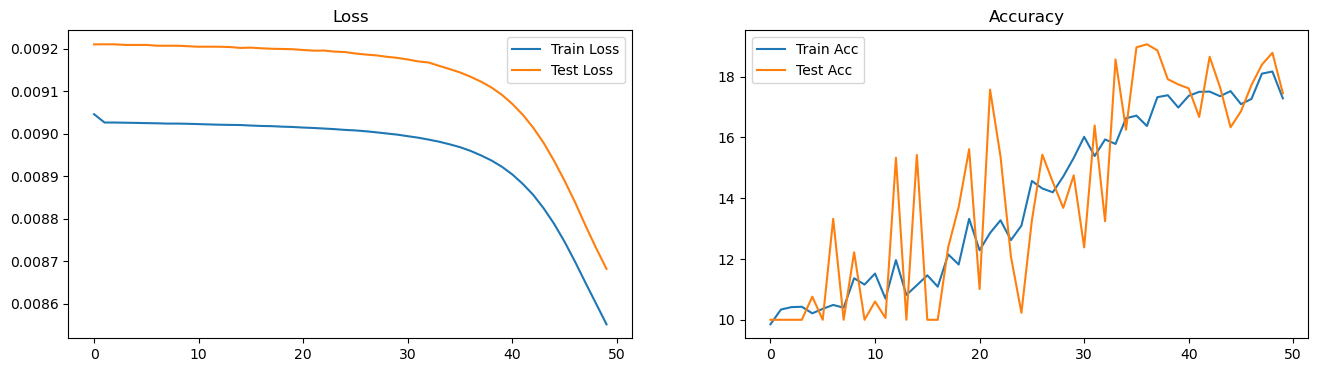

Best Metric
Train Loss: 0.0090, Train Acc: 16.3720
Test Loss: 0.0091, Test Acc: 19.0600


In [18]:
main('cifar10', 'sgd', 'sigmoid', 0)

### ***Adam + ReLU***

Files already downloaded and verified


Files already downloaded and verified


Epoch 1/50
Train Loss: 0.0065, Train Acc: 41.0180
Test Loss: 0.0060, Test Acc: 47.0400



Epoch 2/50
Train Loss: 0.0056, Train Acc: 49.4460
Test Loss: 0.0056, Test Acc: 51.1300



Epoch 3/50
Train Loss: 0.0051, Train Acc: 53.6540
Test Loss: 0.0055, Test Acc: 52.6200



Epoch 4/50
Train Loss: 0.0047, Train Acc: 57.5060
Test Loss: 0.0054, Test Acc: 52.0100



Epoch 5/50
Train Loss: 0.0044, Train Acc: 60.3360
Test Loss: 0.0054, Test Acc: 53.4300



Epoch 6/50
Train Loss: 0.0041, Train Acc: 63.1600
Test Loss: 0.0054, Test Acc: 53.3400



Epoch 7/50
Train Loss: 0.0038, Train Acc: 65.5660
Test Loss: 0.0055, Test Acc: 54.0000



Epoch 8/50
Train Loss: 0.0035, Train Acc: 68.3040
Test Loss: 0.0055, Test Acc: 53.9000



Epoch 9/50
Train Loss: 0.0032, Train Acc: 71.1460
Test Loss: 0.0058, Test Acc: 54.3200



Epoch 10/50
Train Loss: 0.0029, Train Acc: 73.7000
Test Loss: 0.0059, Test Acc: 54.1900



Epoch 11/50
Train Loss: 0.0026, Train Acc: 76.0640
Test Loss: 0.0065, Test Acc: 53.4400



Epoch 12/50
Train Loss: 0.0024, Train Acc: 78.5200
Test Loss: 0.0066, Test Acc: 54.8100



Epoch 13/50
Train Loss: 0.0021, Train Acc: 80.8980
Test Loss: 0.0067, Test Acc: 54.8100



Epoch 14/50
Train Loss: 0.0019, Train Acc: 82.8180
Test Loss: 0.0072, Test Acc: 54.6600



Epoch 15/50
Train Loss: 0.0017, Train Acc: 84.5300
Test Loss: 0.0076, Test Acc: 54.2500



Epoch 16/50
Train Loss: 0.0015, Train Acc: 86.5840
Test Loss: 0.0081, Test Acc: 54.2800



Epoch 17/50
Train Loss: 0.0014, Train Acc: 87.5980
Test Loss: 0.0086, Test Acc: 54.1900



Epoch 18/50
Train Loss: 0.0013, Train Acc: 88.8860
Test Loss: 0.0092, Test Acc: 53.4900



Epoch 19/50
Train Loss: 0.0011, Train Acc: 89.8360
Test Loss: 0.0097, Test Acc: 54.6400



Epoch 20/50
Train Loss: 0.0010, Train Acc: 90.5260
Test Loss: 0.0100, Test Acc: 54.1100



Epoch 21/50
Train Loss: 0.0010, Train Acc: 91.3920
Test Loss: 0.0108, Test Acc: 53.9700



Epoch 22/50
Train Loss: 0.0009, Train Acc: 92.0140
Test Loss: 0.0109, Test Acc: 53.2700



Epoch 23/50
Train Loss: 0.0008, Train Acc: 92.9040
Test Loss: 0.0114, Test Acc: 54.0900



Epoch 24/50
Train Loss: 0.0008, Train Acc: 93.2920
Test Loss: 0.0117, Test Acc: 53.4900



Epoch 25/50
Train Loss: 0.0008, Train Acc: 93.2120
Test Loss: 0.0121, Test Acc: 54.2100



Epoch 26/50
Train Loss: 0.0007, Train Acc: 94.0280
Test Loss: 0.0126, Test Acc: 53.6000



Epoch 27/50
Train Loss: 0.0006, Train Acc: 94.4980
Test Loss: 0.0130, Test Acc: 54.4500



Epoch 28/50
Train Loss: 0.0006, Train Acc: 94.5620
Test Loss: 0.0132, Test Acc: 53.2900



Epoch 29/50
Train Loss: 0.0007, Train Acc: 94.0400
Test Loss: 0.0128, Test Acc: 53.2900



Epoch 30/50
Train Loss: 0.0006, Train Acc: 94.7520
Test Loss: 0.0142, Test Acc: 53.8500



Epoch 31/50
Train Loss: 0.0005, Train Acc: 95.3980
Test Loss: 0.0143, Test Acc: 53.5400



Epoch 32/50
Train Loss: 0.0006, Train Acc: 94.6220
Test Loss: 0.0142, Test Acc: 53.6100



Epoch 33/50
Train Loss: 0.0006, Train Acc: 95.0900
Test Loss: 0.0146, Test Acc: 53.8000



Epoch 34/50
Train Loss: 0.0006, Train Acc: 94.8040
Test Loss: 0.0146, Test Acc: 53.8500



Epoch 35/50
Train Loss: 0.0004, Train Acc: 96.1920
Test Loss: 0.0154, Test Acc: 52.9200



Epoch 36/50
Train Loss: 0.0004, Train Acc: 96.0340
Test Loss: 0.0154, Test Acc: 54.3100



Epoch 37/50
Train Loss: 0.0004, Train Acc: 96.2400
Test Loss: 0.0156, Test Acc: 54.0300



Epoch 38/50
Train Loss: 0.0005, Train Acc: 95.9400
Test Loss: 0.0157, Test Acc: 54.2500



Epoch 39/50
Train Loss: 0.0006, Train Acc: 95.0040
Test Loss: 0.0149, Test Acc: 53.0400



Epoch 40/50
Train Loss: 0.0005, Train Acc: 95.8380
Test Loss: 0.0155, Test Acc: 53.8100



Epoch 41/50
Train Loss: 0.0004, Train Acc: 96.6020
Test Loss: 0.0169, Test Acc: 53.7200



Epoch 42/50
Train Loss: 0.0004, Train Acc: 96.5940
Test Loss: 0.0163, Test Acc: 53.3800



Epoch 43/50
Train Loss: 0.0005, Train Acc: 95.9660
Test Loss: 0.0165, Test Acc: 53.2900



Epoch 44/50
Train Loss: 0.0004, Train Acc: 96.9100
Test Loss: 0.0175, Test Acc: 52.6400



Epoch 45/50
Train Loss: 0.0003, Train Acc: 97.1200
Test Loss: 0.0174, Test Acc: 54.4900



Epoch 46/50
Train Loss: 0.0003, Train Acc: 96.9800
Test Loss: 0.0173, Test Acc: 53.2200



Epoch 47/50
Train Loss: 0.0005, Train Acc: 96.1420
Test Loss: 0.0167, Test Acc: 52.9800



Epoch 48/50
Train Loss: 0.0004, Train Acc: 96.4440
Test Loss: 0.0167, Test Acc: 53.3600



Epoch 49/50
Train Loss: 0.0004, Train Acc: 96.3240
Test Loss: 0.0174, Test Acc: 53.8000



Epoch 50/50
Train Loss: 0.0004, Train Acc: 96.6660
Test Loss: 0.0180, Test Acc: 53.7400



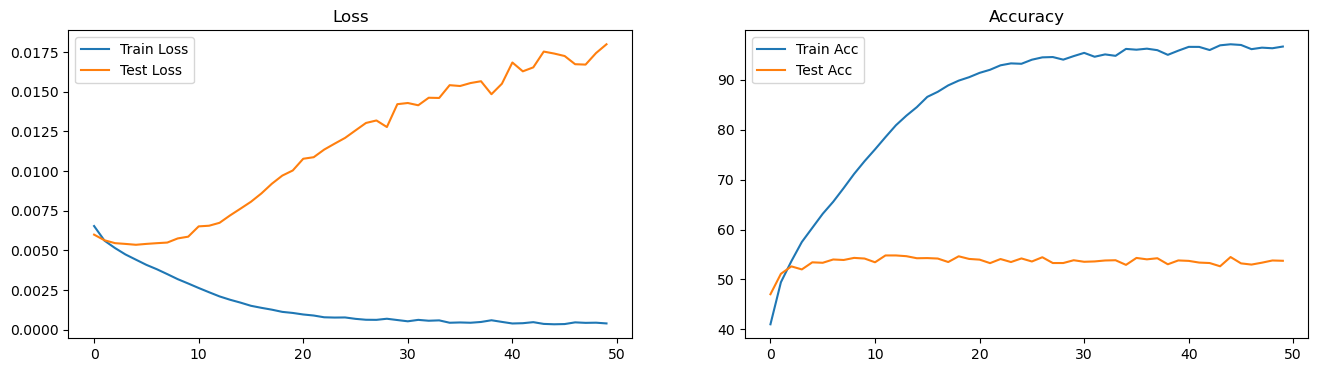

Best Metric
Train Loss: 0.0024, Train Acc: 78.5200
Test Loss: 0.0066, Test Acc: 54.8100


In [19]:
main('cifar10', 'adam', 'relu', 0)

### ***Adam + ReLU + Dropout***

Files already downloaded and verified


Files already downloaded and verified


Epoch 1/50
Train Loss: 0.0071, Train Acc: 35.8420
Test Loss: 0.0063, Test Acc: 44.0100



Epoch 2/50
Train Loss: 0.0063, Train Acc: 43.3360
Test Loss: 0.0059, Test Acc: 48.5300



Epoch 3/50
Train Loss: 0.0060, Train Acc: 46.1920
Test Loss: 0.0058, Test Acc: 49.9200



Epoch 4/50
Train Loss: 0.0057, Train Acc: 48.6680
Test Loss: 0.0055, Test Acc: 51.2400



Epoch 5/50
Train Loss: 0.0056, Train Acc: 49.8140
Test Loss: 0.0055, Test Acc: 51.8700



Epoch 6/50
Train Loss: 0.0054, Train Acc: 51.6260
Test Loss: 0.0054, Test Acc: 52.3600



Epoch 7/50
Train Loss: 0.0053, Train Acc: 52.8020
Test Loss: 0.0053, Test Acc: 52.8200



Epoch 8/50
Train Loss: 0.0051, Train Acc: 53.9520
Test Loss: 0.0053, Test Acc: 53.5600



Epoch 9/50
Train Loss: 0.0050, Train Acc: 54.7740
Test Loss: 0.0053, Test Acc: 53.7900



Epoch 10/50
Train Loss: 0.0049, Train Acc: 56.0140
Test Loss: 0.0052, Test Acc: 54.4000



Epoch 11/50
Train Loss: 0.0048, Train Acc: 56.8120
Test Loss: 0.0052, Test Acc: 54.9600



Epoch 12/50
Train Loss: 0.0047, Train Acc: 57.4740
Test Loss: 0.0052, Test Acc: 55.1000



Epoch 13/50
Train Loss: 0.0047, Train Acc: 57.8240
Test Loss: 0.0051, Test Acc: 55.0100



Epoch 14/50
Train Loss: 0.0045, Train Acc: 58.7420
Test Loss: 0.0051, Test Acc: 55.9700



Epoch 15/50
Train Loss: 0.0045, Train Acc: 59.6220
Test Loss: 0.0051, Test Acc: 54.9300



Epoch 16/50
Train Loss: 0.0044, Train Acc: 60.4480
Test Loss: 0.0051, Test Acc: 55.2300



Epoch 17/50
Train Loss: 0.0043, Train Acc: 60.8200
Test Loss: 0.0051, Test Acc: 55.9800



Epoch 18/50
Train Loss: 0.0042, Train Acc: 61.4400
Test Loss: 0.0051, Test Acc: 55.3400



Epoch 19/50
Train Loss: 0.0042, Train Acc: 61.7260
Test Loss: 0.0051, Test Acc: 56.0800



Epoch 20/50
Train Loss: 0.0041, Train Acc: 62.5580
Test Loss: 0.0051, Test Acc: 55.9300



Epoch 21/50
Train Loss: 0.0041, Train Acc: 63.0060
Test Loss: 0.0051, Test Acc: 55.6700



Epoch 22/50
Train Loss: 0.0040, Train Acc: 63.6360
Test Loss: 0.0050, Test Acc: 56.6300



Epoch 23/50
Train Loss: 0.0040, Train Acc: 63.8460
Test Loss: 0.0051, Test Acc: 56.8000



Epoch 24/50
Train Loss: 0.0039, Train Acc: 64.5920
Test Loss: 0.0051, Test Acc: 56.2000



Epoch 25/50
Train Loss: 0.0039, Train Acc: 65.2400
Test Loss: 0.0051, Test Acc: 55.7300



Epoch 26/50
Train Loss: 0.0038, Train Acc: 65.3680
Test Loss: 0.0051, Test Acc: 55.8700



Epoch 27/50
Train Loss: 0.0038, Train Acc: 65.6880
Test Loss: 0.0051, Test Acc: 55.9200



Epoch 28/50
Train Loss: 0.0037, Train Acc: 66.1960
Test Loss: 0.0051, Test Acc: 56.1300



Epoch 29/50
Train Loss: 0.0037, Train Acc: 66.7280
Test Loss: 0.0051, Test Acc: 56.3300



Epoch 30/50
Train Loss: 0.0036, Train Acc: 67.1360
Test Loss: 0.0052, Test Acc: 56.6400



Epoch 31/50
Train Loss: 0.0036, Train Acc: 67.5100
Test Loss: 0.0052, Test Acc: 56.1300



Epoch 32/50
Train Loss: 0.0035, Train Acc: 67.8280
Test Loss: 0.0052, Test Acc: 56.2300



Epoch 33/50
Train Loss: 0.0035, Train Acc: 68.4800
Test Loss: 0.0052, Test Acc: 56.3700



Epoch 34/50
Train Loss: 0.0035, Train Acc: 68.6720
Test Loss: 0.0052, Test Acc: 55.7300



Epoch 35/50
Train Loss: 0.0034, Train Acc: 68.7480
Test Loss: 0.0052, Test Acc: 56.2000



Epoch 36/50
Train Loss: 0.0034, Train Acc: 69.3080
Test Loss: 0.0053, Test Acc: 55.7800



Epoch 37/50
Train Loss: 0.0034, Train Acc: 69.5720
Test Loss: 0.0052, Test Acc: 56.3500



Epoch 38/50
Train Loss: 0.0033, Train Acc: 69.9260
Test Loss: 0.0052, Test Acc: 56.6200



Epoch 39/50
Train Loss: 0.0033, Train Acc: 69.9920
Test Loss: 0.0052, Test Acc: 56.4400



Epoch 40/50
Train Loss: 0.0032, Train Acc: 70.7020
Test Loss: 0.0052, Test Acc: 56.7100



Epoch 41/50
Train Loss: 0.0032, Train Acc: 70.8400
Test Loss: 0.0052, Test Acc: 56.3000



Epoch 42/50
Train Loss: 0.0032, Train Acc: 71.3160
Test Loss: 0.0053, Test Acc: 56.3000



Epoch 43/50
Train Loss: 0.0032, Train Acc: 71.1380
Test Loss: 0.0053, Test Acc: 56.2300



Epoch 44/50
Train Loss: 0.0031, Train Acc: 71.7580
Test Loss: 0.0053, Test Acc: 56.5800



Epoch 45/50
Train Loss: 0.0031, Train Acc: 71.8680
Test Loss: 0.0053, Test Acc: 56.5200



Epoch 46/50
Train Loss: 0.0031, Train Acc: 72.1180
Test Loss: 0.0054, Test Acc: 56.5900



Epoch 47/50
Train Loss: 0.0031, Train Acc: 72.4340
Test Loss: 0.0053, Test Acc: 56.3800



Epoch 48/50
Train Loss: 0.0030, Train Acc: 72.7800
Test Loss: 0.0054, Test Acc: 55.9800



Epoch 49/50
Train Loss: 0.0030, Train Acc: 73.1300
Test Loss: 0.0054, Test Acc: 56.5100



Epoch 50/50
Train Loss: 0.0030, Train Acc: 73.2640
Test Loss: 0.0053, Test Acc: 56.7400



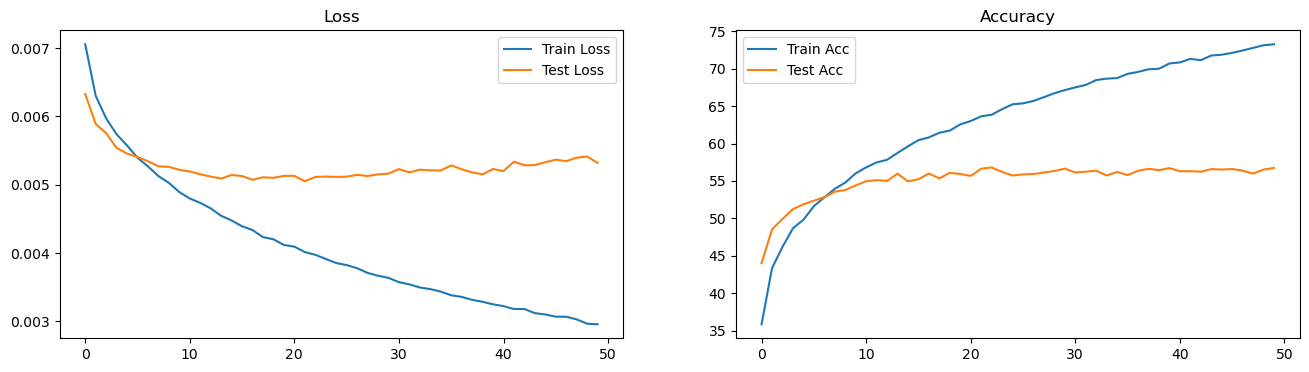

Best Metric
Train Loss: 0.0040, Train Acc: 63.8460
Test Loss: 0.0051, Test Acc: 56.8000


In [20]:
main('cifar10', 'adam', 'relu', 0.3)

# ***CIFAR 100***

### ***SGD + ReLU***

Files already downloaded and verified


Files already downloaded and verified


Epoch 1/50
Train Loss: 0.0180, Train Acc: 1.5020
Test Loss: 0.0184, Test Acc: 1.6600



Epoch 2/50
Train Loss: 0.0180, Train Acc: 2.2860
Test Loss: 0.0184, Test Acc: 2.5500



Epoch 3/50
Train Loss: 0.0180, Train Acc: 2.8100
Test Loss: 0.0184, Test Acc: 2.9100



Epoch 4/50
Train Loss: 0.0180, Train Acc: 2.8840
Test Loss: 0.0183, Test Acc: 3.0100



Epoch 5/50
Train Loss: 0.0179, Train Acc: 2.9920
Test Loss: 0.0182, Test Acc: 3.0500



Epoch 6/50
Train Loss: 0.0178, Train Acc: 3.0980
Test Loss: 0.0181, Test Acc: 3.2500



Epoch 7/50
Train Loss: 0.0177, Train Acc: 3.3860
Test Loss: 0.0180, Test Acc: 3.5600



Epoch 8/50
Train Loss: 0.0176, Train Acc: 3.8880
Test Loss: 0.0179, Test Acc: 4.0100



Epoch 9/50
Train Loss: 0.0174, Train Acc: 4.3000
Test Loss: 0.0177, Test Acc: 4.6200



Epoch 10/50
Train Loss: 0.0171, Train Acc: 4.9540
Test Loss: 0.0174, Test Acc: 5.3000



Epoch 11/50
Train Loss: 0.0168, Train Acc: 5.6960
Test Loss: 0.0170, Test Acc: 6.1100



Epoch 12/50
Train Loss: 0.0165, Train Acc: 6.5940
Test Loss: 0.0167, Test Acc: 6.6700



Epoch 13/50
Train Loss: 0.0162, Train Acc: 7.4780
Test Loss: 0.0164, Test Acc: 7.6700



Epoch 14/50
Train Loss: 0.0160, Train Acc: 8.1080
Test Loss: 0.0163, Test Acc: 7.9100



Epoch 15/50
Train Loss: 0.0158, Train Acc: 8.5880
Test Loss: 0.0161, Test Acc: 8.2600



Epoch 16/50
Train Loss: 0.0156, Train Acc: 9.0260
Test Loss: 0.0160, Test Acc: 9.0200



Epoch 17/50
Train Loss: 0.0155, Train Acc: 9.4440
Test Loss: 0.0159, Test Acc: 9.6200



Epoch 18/50
Train Loss: 0.0154, Train Acc: 9.8940
Test Loss: 0.0158, Test Acc: 10.0900



Epoch 19/50
Train Loss: 0.0153, Train Acc: 10.3100
Test Loss: 0.0156, Test Acc: 10.6000



Epoch 20/50
Train Loss: 0.0152, Train Acc: 10.8240
Test Loss: 0.0155, Test Acc: 11.1500



Epoch 21/50
Train Loss: 0.0151, Train Acc: 11.3520
Test Loss: 0.0154, Test Acc: 11.7100



Epoch 22/50
Train Loss: 0.0150, Train Acc: 11.8940
Test Loss: 0.0153, Test Acc: 12.1200



Epoch 23/50
Train Loss: 0.0148, Train Acc: 12.4280
Test Loss: 0.0152, Test Acc: 12.4200



Epoch 24/50
Train Loss: 0.0147, Train Acc: 12.8480
Test Loss: 0.0151, Test Acc: 12.9600



Epoch 25/50
Train Loss: 0.0146, Train Acc: 13.3340
Test Loss: 0.0150, Test Acc: 13.4300



Epoch 26/50
Train Loss: 0.0146, Train Acc: 13.7740
Test Loss: 0.0150, Test Acc: 13.7000



Epoch 27/50
Train Loss: 0.0145, Train Acc: 14.1900
Test Loss: 0.0149, Test Acc: 14.0900



Epoch 28/50
Train Loss: 0.0144, Train Acc: 14.4520
Test Loss: 0.0148, Test Acc: 14.0600



Epoch 29/50
Train Loss: 0.0143, Train Acc: 14.8720
Test Loss: 0.0147, Test Acc: 14.8300



Epoch 30/50
Train Loss: 0.0143, Train Acc: 15.2860
Test Loss: 0.0147, Test Acc: 14.9600



Epoch 31/50
Train Loss: 0.0142, Train Acc: 15.4540
Test Loss: 0.0146, Test Acc: 15.0100



Epoch 32/50
Train Loss: 0.0141, Train Acc: 15.7420
Test Loss: 0.0146, Test Acc: 15.7300



Epoch 33/50
Train Loss: 0.0141, Train Acc: 16.0640
Test Loss: 0.0145, Test Acc: 15.9600



Epoch 34/50
Train Loss: 0.0140, Train Acc: 16.3080
Test Loss: 0.0145, Test Acc: 15.9300



Epoch 35/50
Train Loss: 0.0139, Train Acc: 16.6380
Test Loss: 0.0144, Test Acc: 16.3500



Epoch 36/50
Train Loss: 0.0139, Train Acc: 16.8560
Test Loss: 0.0144, Test Acc: 16.1300



Epoch 37/50
Train Loss: 0.0138, Train Acc: 17.1100
Test Loss: 0.0143, Test Acc: 16.6000



Epoch 38/50
Train Loss: 0.0138, Train Acc: 17.2320
Test Loss: 0.0143, Test Acc: 16.8800



Epoch 39/50
Train Loss: 0.0137, Train Acc: 17.6820
Test Loss: 0.0142, Test Acc: 17.0000



Epoch 40/50
Train Loss: 0.0137, Train Acc: 17.8420
Test Loss: 0.0142, Test Acc: 17.2900



Epoch 41/50
Train Loss: 0.0136, Train Acc: 18.0360
Test Loss: 0.0141, Test Acc: 17.5800



Epoch 42/50
Train Loss: 0.0136, Train Acc: 18.2520
Test Loss: 0.0141, Test Acc: 17.6300



Epoch 43/50
Train Loss: 0.0135, Train Acc: 18.4980
Test Loss: 0.0141, Test Acc: 17.7400



Epoch 44/50
Train Loss: 0.0135, Train Acc: 18.7040
Test Loss: 0.0140, Test Acc: 17.9500



Epoch 45/50
Train Loss: 0.0134, Train Acc: 18.9360
Test Loss: 0.0140, Test Acc: 18.0400



Epoch 46/50
Train Loss: 0.0134, Train Acc: 19.3020
Test Loss: 0.0140, Test Acc: 18.2000



Epoch 47/50
Train Loss: 0.0133, Train Acc: 19.5040
Test Loss: 0.0139, Test Acc: 18.5300



Epoch 48/50
Train Loss: 0.0133, Train Acc: 19.5680
Test Loss: 0.0139, Test Acc: 18.8500



Epoch 49/50
Train Loss: 0.0132, Train Acc: 19.8500
Test Loss: 0.0139, Test Acc: 18.9400



Epoch 50/50
Train Loss: 0.0132, Train Acc: 20.0680
Test Loss: 0.0138, Test Acc: 19.0300



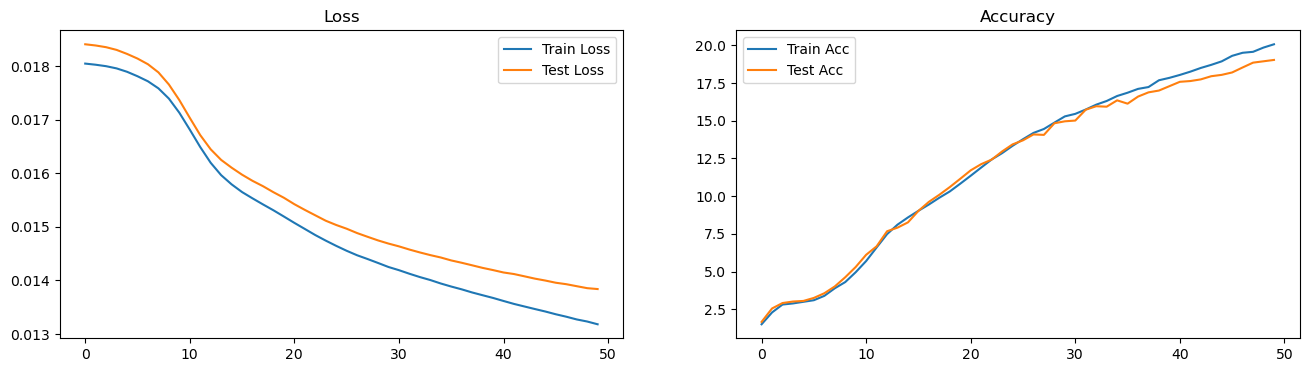

Best Metric
Train Loss: 0.0132, Train Acc: 20.0680
Test Loss: 0.0138, Test Acc: 19.0300


In [21]:
main('cifar100', 'sgd', 'relu', 0)

### ***SGD + Leaky ReLU***

Files already downloaded and verified


Files already downloaded and verified


Epoch 1/50
Train Loss: 0.0180, Train Acc: 1.1660
Test Loss: 0.0184, Test Acc: 1.3500



Epoch 2/50
Train Loss: 0.0180, Train Acc: 1.3220
Test Loss: 0.0184, Test Acc: 1.4100



Epoch 3/50
Train Loss: 0.0180, Train Acc: 1.6540
Test Loss: 0.0184, Test Acc: 2.0700



Epoch 4/50
Train Loss: 0.0180, Train Acc: 2.2960
Test Loss: 0.0183, Test Acc: 2.4400



Epoch 5/50
Train Loss: 0.0179, Train Acc: 2.5820
Test Loss: 0.0182, Test Acc: 2.7500



Epoch 6/50
Train Loss: 0.0178, Train Acc: 2.7760
Test Loss: 0.0181, Test Acc: 3.0400



Epoch 7/50
Train Loss: 0.0177, Train Acc: 3.2620
Test Loss: 0.0180, Test Acc: 3.5200



Epoch 8/50
Train Loss: 0.0175, Train Acc: 4.0360
Test Loss: 0.0178, Test Acc: 4.1900



Epoch 9/50
Train Loss: 0.0173, Train Acc: 4.7480
Test Loss: 0.0175, Test Acc: 5.2100



Epoch 10/50
Train Loss: 0.0169, Train Acc: 5.7280
Test Loss: 0.0171, Test Acc: 5.6800



Epoch 11/50
Train Loss: 0.0166, Train Acc: 6.3020
Test Loss: 0.0168, Test Acc: 6.3100



Epoch 12/50
Train Loss: 0.0163, Train Acc: 6.8720
Test Loss: 0.0165, Test Acc: 7.1000



Epoch 13/50
Train Loss: 0.0160, Train Acc: 7.5920
Test Loss: 0.0163, Test Acc: 7.5700



Epoch 14/50
Train Loss: 0.0159, Train Acc: 8.1920
Test Loss: 0.0162, Test Acc: 8.1200



Epoch 15/50
Train Loss: 0.0157, Train Acc: 8.6960
Test Loss: 0.0160, Test Acc: 8.6900



Epoch 16/50
Train Loss: 0.0156, Train Acc: 9.2540
Test Loss: 0.0159, Test Acc: 9.2500



Epoch 17/50
Train Loss: 0.0154, Train Acc: 9.7240
Test Loss: 0.0158, Test Acc: 10.1500



Epoch 18/50
Train Loss: 0.0153, Train Acc: 10.3200
Test Loss: 0.0157, Test Acc: 10.6900



Epoch 19/50
Train Loss: 0.0152, Train Acc: 10.7580
Test Loss: 0.0156, Test Acc: 11.0600



Epoch 20/50
Train Loss: 0.0151, Train Acc: 11.3260
Test Loss: 0.0154, Test Acc: 11.5500



Epoch 21/50
Train Loss: 0.0150, Train Acc: 11.7680
Test Loss: 0.0153, Test Acc: 12.3300



Epoch 22/50
Train Loss: 0.0149, Train Acc: 12.3180
Test Loss: 0.0152, Test Acc: 12.4100



Epoch 23/50
Train Loss: 0.0148, Train Acc: 12.8080
Test Loss: 0.0151, Test Acc: 13.0100



Epoch 24/50
Train Loss: 0.0147, Train Acc: 13.3520
Test Loss: 0.0150, Test Acc: 13.2000



Epoch 25/50
Train Loss: 0.0146, Train Acc: 13.6960
Test Loss: 0.0150, Test Acc: 13.6600



Epoch 26/50
Train Loss: 0.0145, Train Acc: 14.1300
Test Loss: 0.0149, Test Acc: 13.9100



Epoch 27/50
Train Loss: 0.0144, Train Acc: 14.6660
Test Loss: 0.0148, Test Acc: 14.2800



Epoch 28/50
Train Loss: 0.0143, Train Acc: 14.9620
Test Loss: 0.0148, Test Acc: 14.4500



Epoch 29/50
Train Loss: 0.0143, Train Acc: 15.2120
Test Loss: 0.0147, Test Acc: 14.9300



Epoch 30/50
Train Loss: 0.0142, Train Acc: 15.5260
Test Loss: 0.0147, Test Acc: 15.0400



Epoch 31/50
Train Loss: 0.0141, Train Acc: 15.8360
Test Loss: 0.0146, Test Acc: 15.4800



Epoch 32/50
Train Loss: 0.0141, Train Acc: 16.0920
Test Loss: 0.0146, Test Acc: 15.5200



Epoch 33/50
Train Loss: 0.0140, Train Acc: 16.4900
Test Loss: 0.0145, Test Acc: 16.0100



Epoch 34/50
Train Loss: 0.0140, Train Acc: 16.6740
Test Loss: 0.0144, Test Acc: 15.9400



Epoch 35/50
Train Loss: 0.0139, Train Acc: 16.8060
Test Loss: 0.0144, Test Acc: 16.2100



Epoch 36/50
Train Loss: 0.0139, Train Acc: 17.1760
Test Loss: 0.0144, Test Acc: 16.3700



Epoch 37/50
Train Loss: 0.0138, Train Acc: 17.3520
Test Loss: 0.0143, Test Acc: 16.4000



Epoch 38/50
Train Loss: 0.0137, Train Acc: 17.6360
Test Loss: 0.0143, Test Acc: 16.9000



Epoch 39/50
Train Loss: 0.0137, Train Acc: 17.8700
Test Loss: 0.0142, Test Acc: 17.0600



Epoch 40/50
Train Loss: 0.0136, Train Acc: 18.0060
Test Loss: 0.0142, Test Acc: 17.5800



Epoch 41/50
Train Loss: 0.0136, Train Acc: 18.1620
Test Loss: 0.0141, Test Acc: 17.4000



Epoch 42/50
Train Loss: 0.0135, Train Acc: 18.4300
Test Loss: 0.0141, Test Acc: 17.8100



Epoch 43/50
Train Loss: 0.0135, Train Acc: 18.6460
Test Loss: 0.0141, Test Acc: 18.0000



Epoch 44/50
Train Loss: 0.0134, Train Acc: 18.7500
Test Loss: 0.0140, Test Acc: 17.9200



Epoch 45/50
Train Loss: 0.0134, Train Acc: 19.1100
Test Loss: 0.0140, Test Acc: 18.3600



Epoch 46/50
Train Loss: 0.0134, Train Acc: 19.2100
Test Loss: 0.0140, Test Acc: 18.3900



Epoch 47/50
Train Loss: 0.0133, Train Acc: 19.4480
Test Loss: 0.0139, Test Acc: 18.4800



Epoch 48/50
Train Loss: 0.0133, Train Acc: 19.7360
Test Loss: 0.0139, Test Acc: 18.6900



Epoch 49/50
Train Loss: 0.0132, Train Acc: 19.8500
Test Loss: 0.0139, Test Acc: 18.7300



Epoch 50/50
Train Loss: 0.0132, Train Acc: 20.0300
Test Loss: 0.0138, Test Acc: 18.7700



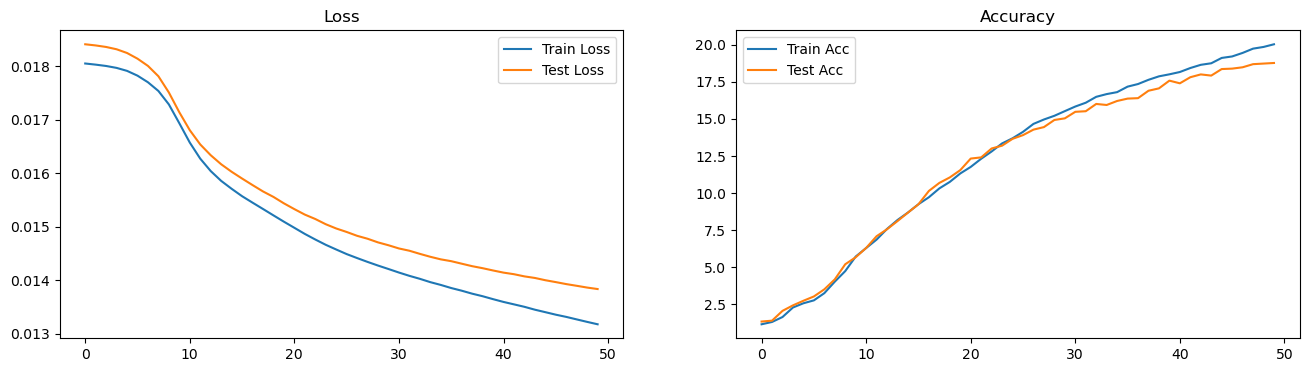

Best Metric
Train Loss: 0.0132, Train Acc: 20.0300
Test Loss: 0.0138, Test Acc: 18.7700


In [22]:
main('cifar100', 'sgd', 'leaky_relu', 0)

### ***SGD + Sigmoid***

Files already downloaded and verified


Files already downloaded and verified


Epoch 1/50
Train Loss: 0.0182, Train Acc: 0.9700
Test Loss: 0.0185, Test Acc: 1.0000



Epoch 2/50
Train Loss: 0.0181, Train Acc: 0.9560
Test Loss: 0.0184, Test Acc: 1.0000



Epoch 3/50
Train Loss: 0.0181, Train Acc: 1.0000
Test Loss: 0.0184, Test Acc: 1.0000



Epoch 4/50
Train Loss: 0.0181, Train Acc: 0.9440
Test Loss: 0.0184, Test Acc: 1.0000



Epoch 5/50
Train Loss: 0.0181, Train Acc: 0.9200
Test Loss: 0.0184, Test Acc: 1.0000



Epoch 6/50
Train Loss: 0.0181, Train Acc: 0.9840
Test Loss: 0.0184, Test Acc: 1.0200



Epoch 7/50
Train Loss: 0.0181, Train Acc: 0.9120
Test Loss: 0.0184, Test Acc: 1.3300



Epoch 8/50
Train Loss: 0.0181, Train Acc: 0.9520
Test Loss: 0.0184, Test Acc: 0.9200



Epoch 9/50
Train Loss: 0.0181, Train Acc: 0.9020
Test Loss: 0.0184, Test Acc: 1.0700



Epoch 10/50
Train Loss: 0.0181, Train Acc: 0.9580
Test Loss: 0.0184, Test Acc: 1.0300



Epoch 11/50
Train Loss: 0.0181, Train Acc: 0.9020
Test Loss: 0.0184, Test Acc: 0.9900



Epoch 12/50
Train Loss: 0.0181, Train Acc: 0.9960
Test Loss: 0.0184, Test Acc: 1.4200



Epoch 13/50
Train Loss: 0.0181, Train Acc: 1.0260
Test Loss: 0.0184, Test Acc: 0.9900



Epoch 14/50
Train Loss: 0.0181, Train Acc: 0.9000
Test Loss: 0.0184, Test Acc: 1.1200



Epoch 15/50
Train Loss: 0.0181, Train Acc: 0.9260
Test Loss: 0.0184, Test Acc: 1.2500



Epoch 16/50
Train Loss: 0.0181, Train Acc: 1.0600
Test Loss: 0.0184, Test Acc: 1.0000



Epoch 17/50
Train Loss: 0.0181, Train Acc: 0.9500
Test Loss: 0.0184, Test Acc: 1.4800



Epoch 18/50
Train Loss: 0.0181, Train Acc: 0.9400
Test Loss: 0.0184, Test Acc: 1.3100



Epoch 19/50
Train Loss: 0.0181, Train Acc: 1.0380
Test Loss: 0.0184, Test Acc: 1.0000



Epoch 20/50
Train Loss: 0.0181, Train Acc: 0.9840
Test Loss: 0.0184, Test Acc: 1.0000



Epoch 21/50
Train Loss: 0.0181, Train Acc: 0.9760
Test Loss: 0.0184, Test Acc: 1.0000



Epoch 22/50
Train Loss: 0.0181, Train Acc: 0.9800
Test Loss: 0.0184, Test Acc: 1.1400



Epoch 23/50
Train Loss: 0.0181, Train Acc: 1.0160
Test Loss: 0.0184, Test Acc: 1.0000



Epoch 24/50
Train Loss: 0.0181, Train Acc: 1.0640
Test Loss: 0.0184, Test Acc: 1.0700



Epoch 25/50
Train Loss: 0.0181, Train Acc: 0.9420
Test Loss: 0.0184, Test Acc: 1.1800



Epoch 26/50
Train Loss: 0.0181, Train Acc: 1.0180
Test Loss: 0.0184, Test Acc: 1.4100



Epoch 27/50
Train Loss: 0.0181, Train Acc: 1.0180
Test Loss: 0.0184, Test Acc: 1.5300



Epoch 28/50
Train Loss: 0.0181, Train Acc: 1.0480
Test Loss: 0.0184, Test Acc: 1.0700



Epoch 29/50
Train Loss: 0.0181, Train Acc: 1.0800
Test Loss: 0.0184, Test Acc: 1.3800



Epoch 30/50
Train Loss: 0.0181, Train Acc: 1.1060
Test Loss: 0.0184, Test Acc: 1.2100



Epoch 31/50
Train Loss: 0.0181, Train Acc: 1.1620
Test Loss: 0.0184, Test Acc: 0.9800



Epoch 32/50
Train Loss: 0.0181, Train Acc: 0.9420
Test Loss: 0.0184, Test Acc: 1.1300



Epoch 33/50
Train Loss: 0.0181, Train Acc: 1.0940
Test Loss: 0.0184, Test Acc: 1.5400



Epoch 34/50
Train Loss: 0.0181, Train Acc: 1.0580
Test Loss: 0.0184, Test Acc: 1.2400



Epoch 35/50
Train Loss: 0.0181, Train Acc: 1.0160
Test Loss: 0.0184, Test Acc: 1.8500



Epoch 36/50
Train Loss: 0.0181, Train Acc: 1.0600
Test Loss: 0.0184, Test Acc: 1.1600



Epoch 37/50
Train Loss: 0.0181, Train Acc: 1.0220
Test Loss: 0.0184, Test Acc: 1.7100



Epoch 38/50
Train Loss: 0.0181, Train Acc: 1.1060
Test Loss: 0.0184, Test Acc: 1.8300



Epoch 39/50
Train Loss: 0.0181, Train Acc: 0.9620
Test Loss: 0.0184, Test Acc: 1.7000



Epoch 40/50
Train Loss: 0.0181, Train Acc: 1.2080
Test Loss: 0.0184, Test Acc: 1.3100



Epoch 41/50
Train Loss: 0.0181, Train Acc: 1.1400
Test Loss: 0.0184, Test Acc: 0.9800



Epoch 42/50
Train Loss: 0.0181, Train Acc: 1.1320
Test Loss: 0.0184, Test Acc: 1.7900



Epoch 43/50
Train Loss: 0.0181, Train Acc: 1.0220
Test Loss: 0.0184, Test Acc: 1.7700



Epoch 44/50
Train Loss: 0.0181, Train Acc: 1.2400
Test Loss: 0.0184, Test Acc: 1.9600



Epoch 45/50
Train Loss: 0.0180, Train Acc: 1.1960
Test Loss: 0.0184, Test Acc: 1.2600



Epoch 46/50
Train Loss: 0.0180, Train Acc: 1.2640
Test Loss: 0.0184, Test Acc: 2.0000



Epoch 47/50
Train Loss: 0.0180, Train Acc: 1.2860
Test Loss: 0.0184, Test Acc: 1.9000



Epoch 48/50
Train Loss: 0.0180, Train Acc: 1.1800
Test Loss: 0.0184, Test Acc: 1.1100



Epoch 49/50
Train Loss: 0.0180, Train Acc: 1.3260
Test Loss: 0.0184, Test Acc: 1.9500



Epoch 50/50
Train Loss: 0.0180, Train Acc: 1.2640
Test Loss: 0.0184, Test Acc: 1.7400



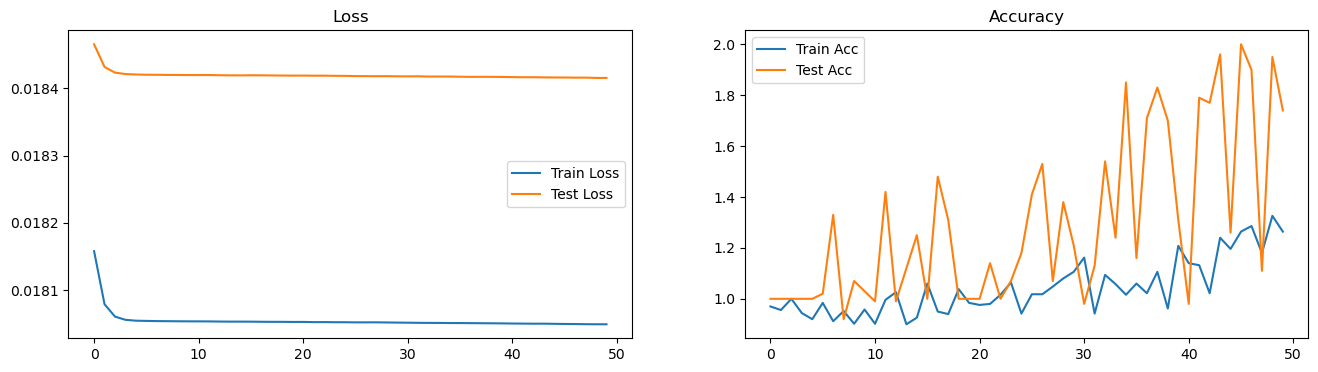

Best Metric
Train Loss: 0.0180, Train Acc: 1.2640
Test Loss: 0.0184, Test Acc: 2.0000


In [23]:
main('cifar100', 'sgd', 'sigmoid', 0)

### ***Adam + ReLU***

Files already downloaded and verified


Files already downloaded and verified


Epoch 1/50
Train Loss: 0.0151, Train Acc: 11.7560
Test Loss: 0.0144, Test Acc: 15.8900



Epoch 2/50
Train Loss: 0.0134, Train Acc: 18.9340
Test Loss: 0.0137, Test Acc: 19.1200



Epoch 3/50
Train Loss: 0.0125, Train Acc: 22.8880
Test Loss: 0.0132, Test Acc: 21.8600



Epoch 4/50
Train Loss: 0.0118, Train Acc: 25.8740
Test Loss: 0.0129, Test Acc: 23.0600



Epoch 5/50
Train Loss: 0.0113, Train Acc: 28.6900
Test Loss: 0.0129, Test Acc: 24.4600



Epoch 6/50
Train Loss: 0.0108, Train Acc: 31.1960
Test Loss: 0.0128, Test Acc: 24.8600



Epoch 7/50
Train Loss: 0.0102, Train Acc: 33.8760
Test Loss: 0.0128, Test Acc: 25.4000



Epoch 8/50
Train Loss: 0.0097, Train Acc: 36.4520
Test Loss: 0.0129, Test Acc: 25.1700



Epoch 9/50
Train Loss: 0.0092, Train Acc: 39.1020
Test Loss: 0.0131, Test Acc: 25.2700



Epoch 10/50
Train Loss: 0.0087, Train Acc: 41.8820
Test Loss: 0.0131, Test Acc: 26.1700



Epoch 11/50
Train Loss: 0.0082, Train Acc: 44.6020
Test Loss: 0.0135, Test Acc: 26.5600



Epoch 12/50
Train Loss: 0.0077, Train Acc: 47.1800
Test Loss: 0.0138, Test Acc: 25.9700



Epoch 13/50
Train Loss: 0.0073, Train Acc: 49.9740
Test Loss: 0.0142, Test Acc: 25.6600



Epoch 14/50
Train Loss: 0.0068, Train Acc: 52.9760
Test Loss: 0.0146, Test Acc: 25.7700



Epoch 15/50
Train Loss: 0.0063, Train Acc: 56.0320
Test Loss: 0.0151, Test Acc: 25.7400



Epoch 16/50
Train Loss: 0.0059, Train Acc: 58.6440
Test Loss: 0.0155, Test Acc: 25.3200



Epoch 17/50
Train Loss: 0.0055, Train Acc: 61.1060
Test Loss: 0.0160, Test Acc: 25.5400



Epoch 18/50
Train Loss: 0.0051, Train Acc: 63.5180
Test Loss: 0.0169, Test Acc: 25.1600



Epoch 19/50
Train Loss: 0.0047, Train Acc: 65.5180
Test Loss: 0.0174, Test Acc: 24.8900



Epoch 20/50
Train Loss: 0.0044, Train Acc: 68.4080
Test Loss: 0.0182, Test Acc: 25.2100



Epoch 21/50
Train Loss: 0.0040, Train Acc: 70.5220
Test Loss: 0.0187, Test Acc: 25.0200



Epoch 22/50
Train Loss: 0.0038, Train Acc: 72.3420
Test Loss: 0.0198, Test Acc: 24.6100



Epoch 23/50
Train Loss: 0.0035, Train Acc: 73.9360
Test Loss: 0.0204, Test Acc: 24.8300



Epoch 24/50
Train Loss: 0.0032, Train Acc: 76.1200
Test Loss: 0.0211, Test Acc: 24.6600



Epoch 25/50
Train Loss: 0.0030, Train Acc: 77.5680
Test Loss: 0.0221, Test Acc: 24.6600



Epoch 26/50
Train Loss: 0.0028, Train Acc: 79.0320
Test Loss: 0.0229, Test Acc: 24.3100



Epoch 27/50
Train Loss: 0.0026, Train Acc: 80.3740
Test Loss: 0.0235, Test Acc: 24.1500



Epoch 28/50
Train Loss: 0.0025, Train Acc: 81.0900
Test Loss: 0.0243, Test Acc: 24.3100



Epoch 29/50
Train Loss: 0.0023, Train Acc: 82.2700
Test Loss: 0.0255, Test Acc: 23.9200



Epoch 30/50
Train Loss: 0.0022, Train Acc: 83.3020
Test Loss: 0.0263, Test Acc: 24.5000



Epoch 31/50
Train Loss: 0.0021, Train Acc: 83.3960
Test Loss: 0.0268, Test Acc: 23.3700



Epoch 32/50
Train Loss: 0.0019, Train Acc: 84.9520
Test Loss: 0.0281, Test Acc: 23.9200



Epoch 33/50
Train Loss: 0.0018, Train Acc: 85.4900
Test Loss: 0.0285, Test Acc: 23.4900



Epoch 34/50
Train Loss: 0.0017, Train Acc: 86.6560
Test Loss: 0.0296, Test Acc: 23.3900



Epoch 35/50
Train Loss: 0.0017, Train Acc: 86.3960
Test Loss: 0.0297, Test Acc: 23.4000



Epoch 36/50
Train Loss: 0.0017, Train Acc: 86.9580
Test Loss: 0.0308, Test Acc: 22.7800



Epoch 37/50
Train Loss: 0.0016, Train Acc: 86.9000
Test Loss: 0.0311, Test Acc: 23.0400



Epoch 38/50
Train Loss: 0.0016, Train Acc: 87.2780
Test Loss: 0.0324, Test Acc: 23.4000



Epoch 39/50
Train Loss: 0.0014, Train Acc: 88.4060
Test Loss: 0.0332, Test Acc: 23.6700



Epoch 40/50
Train Loss: 0.0014, Train Acc: 88.3720
Test Loss: 0.0340, Test Acc: 23.6900



Epoch 41/50
Train Loss: 0.0015, Train Acc: 88.1240
Test Loss: 0.0348, Test Acc: 23.3800



Epoch 42/50
Train Loss: 0.0014, Train Acc: 88.6820
Test Loss: 0.0356, Test Acc: 23.4000



Epoch 43/50
Train Loss: 0.0014, Train Acc: 88.8340
Test Loss: 0.0359, Test Acc: 23.0500



Epoch 44/50
Train Loss: 0.0014, Train Acc: 88.9680
Test Loss: 0.0363, Test Acc: 23.7400



Epoch 45/50
Train Loss: 0.0012, Train Acc: 90.2740
Test Loss: 0.0376, Test Acc: 23.7200



Epoch 46/50
Train Loss: 0.0013, Train Acc: 89.6660
Test Loss: 0.0377, Test Acc: 23.2800



Epoch 47/50
Train Loss: 0.0013, Train Acc: 89.8660
Test Loss: 0.0384, Test Acc: 23.1200



Epoch 48/50
Train Loss: 0.0014, Train Acc: 88.9120
Test Loss: 0.0390, Test Acc: 23.4100



Epoch 49/50
Train Loss: 0.0011, Train Acc: 90.8840
Test Loss: 0.0395, Test Acc: 22.8700



Epoch 50/50
Train Loss: 0.0011, Train Acc: 91.2220
Test Loss: 0.0400, Test Acc: 23.5500



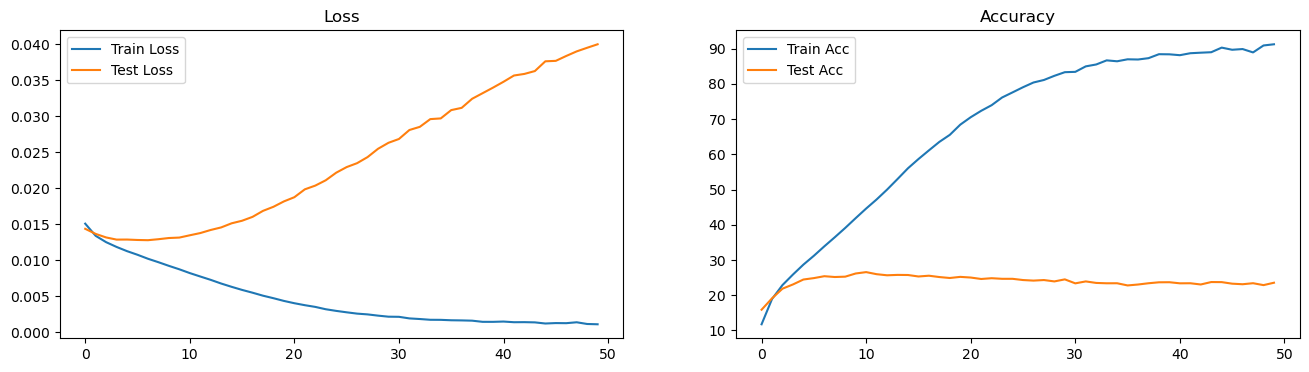

Best Metric
Train Loss: 0.0082, Train Acc: 44.6020
Test Loss: 0.0135, Test Acc: 26.5600


In [24]:
main('cifar100', 'adam', 'relu', 0)

### ***Adam + ReLU + Dropout***

Files already downloaded and verified


Files already downloaded and verified


Epoch 1/50
Train Loss: 0.0162, Train Acc: 7.0540
Test Loss: 0.0151, Test Acc: 13.3400



Epoch 2/50
Train Loss: 0.0149, Train Acc: 11.8780
Test Loss: 0.0144, Test Acc: 16.0700



Epoch 3/50
Train Loss: 0.0143, Train Acc: 14.6300
Test Loss: 0.0139, Test Acc: 18.2600



Epoch 4/50
Train Loss: 0.0139, Train Acc: 16.0920
Test Loss: 0.0137, Test Acc: 19.0300



Epoch 5/50
Train Loss: 0.0136, Train Acc: 17.5700
Test Loss: 0.0134, Test Acc: 20.5000



Epoch 6/50
Train Loss: 0.0134, Train Acc: 18.4840
Test Loss: 0.0134, Test Acc: 21.1200



Epoch 7/50
Train Loss: 0.0132, Train Acc: 18.9620
Test Loss: 0.0133, Test Acc: 21.3200



Epoch 8/50
Train Loss: 0.0130, Train Acc: 19.9460
Test Loss: 0.0131, Test Acc: 22.0800



Epoch 9/50
Train Loss: 0.0129, Train Acc: 20.7400
Test Loss: 0.0130, Test Acc: 22.5100



Epoch 10/50
Train Loss: 0.0128, Train Acc: 21.2300
Test Loss: 0.0130, Test Acc: 22.9400



Epoch 11/50
Train Loss: 0.0126, Train Acc: 21.6460
Test Loss: 0.0129, Test Acc: 22.8900



Epoch 12/50
Train Loss: 0.0125, Train Acc: 22.1080
Test Loss: 0.0128, Test Acc: 23.4500



Epoch 13/50
Train Loss: 0.0124, Train Acc: 22.5320
Test Loss: 0.0128, Test Acc: 23.5100



Epoch 14/50
Train Loss: 0.0123, Train Acc: 23.0280
Test Loss: 0.0128, Test Acc: 23.9100



Epoch 15/50
Train Loss: 0.0122, Train Acc: 23.3320
Test Loss: 0.0127, Test Acc: 24.0400



Epoch 16/50
Train Loss: 0.0121, Train Acc: 23.5940
Test Loss: 0.0127, Test Acc: 24.0500



Epoch 17/50
Train Loss: 0.0120, Train Acc: 24.0420
Test Loss: 0.0127, Test Acc: 23.9900



Epoch 18/50
Train Loss: 0.0119, Train Acc: 24.2960
Test Loss: 0.0127, Test Acc: 24.3000



Epoch 19/50
Train Loss: 0.0119, Train Acc: 24.9160
Test Loss: 0.0126, Test Acc: 25.0300



Epoch 20/50
Train Loss: 0.0117, Train Acc: 25.2020
Test Loss: 0.0126, Test Acc: 24.4900



Epoch 21/50
Train Loss: 0.0117, Train Acc: 25.5460
Test Loss: 0.0126, Test Acc: 25.1500



Epoch 22/50
Train Loss: 0.0116, Train Acc: 26.2900
Test Loss: 0.0125, Test Acc: 24.5800



Epoch 23/50
Train Loss: 0.0116, Train Acc: 26.2640
Test Loss: 0.0125, Test Acc: 24.9600



Epoch 24/50
Train Loss: 0.0115, Train Acc: 26.4260
Test Loss: 0.0125, Test Acc: 24.5600



Epoch 25/50
Train Loss: 0.0114, Train Acc: 27.0180
Test Loss: 0.0126, Test Acc: 25.0100



Epoch 26/50
Train Loss: 0.0114, Train Acc: 27.1240
Test Loss: 0.0125, Test Acc: 25.8400



Epoch 27/50
Train Loss: 0.0113, Train Acc: 27.6120
Test Loss: 0.0125, Test Acc: 25.2700



Epoch 28/50
Train Loss: 0.0113, Train Acc: 27.9640
Test Loss: 0.0125, Test Acc: 25.5100



Epoch 29/50
Train Loss: 0.0112, Train Acc: 28.0280
Test Loss: 0.0125, Test Acc: 25.8800



Epoch 30/50
Train Loss: 0.0112, Train Acc: 28.1420
Test Loss: 0.0124, Test Acc: 25.4500



Epoch 31/50
Train Loss: 0.0111, Train Acc: 28.1700
Test Loss: 0.0125, Test Acc: 25.8500



Epoch 32/50
Train Loss: 0.0110, Train Acc: 28.8260
Test Loss: 0.0124, Test Acc: 25.9500



Epoch 33/50
Train Loss: 0.0110, Train Acc: 29.1080
Test Loss: 0.0125, Test Acc: 25.7000



Epoch 34/50
Train Loss: 0.0109, Train Acc: 29.1840
Test Loss: 0.0125, Test Acc: 25.9700



Epoch 35/50
Train Loss: 0.0109, Train Acc: 29.6080
Test Loss: 0.0125, Test Acc: 25.5200



Epoch 36/50
Train Loss: 0.0109, Train Acc: 29.4680
Test Loss: 0.0125, Test Acc: 25.6100



Epoch 37/50
Train Loss: 0.0108, Train Acc: 29.8480
Test Loss: 0.0125, Test Acc: 25.8400



Epoch 38/50
Train Loss: 0.0107, Train Acc: 30.0080
Test Loss: 0.0125, Test Acc: 26.1200



Epoch 39/50
Train Loss: 0.0107, Train Acc: 30.2060
Test Loss: 0.0124, Test Acc: 26.6100



Epoch 40/50
Train Loss: 0.0106, Train Acc: 30.6260
Test Loss: 0.0124, Test Acc: 26.2900



Epoch 41/50
Train Loss: 0.0106, Train Acc: 30.5960
Test Loss: 0.0124, Test Acc: 26.2700



Epoch 42/50
Train Loss: 0.0106, Train Acc: 30.8780
Test Loss: 0.0125, Test Acc: 25.9000



Epoch 43/50
Train Loss: 0.0105, Train Acc: 31.0920
Test Loss: 0.0125, Test Acc: 26.1000



Epoch 44/50
Train Loss: 0.0105, Train Acc: 31.4280
Test Loss: 0.0125, Test Acc: 26.0500



Epoch 45/50
Train Loss: 0.0105, Train Acc: 31.5500
Test Loss: 0.0125, Test Acc: 26.3600



Epoch 46/50
Train Loss: 0.0104, Train Acc: 31.9080
Test Loss: 0.0125, Test Acc: 26.2600



Epoch 47/50
Train Loss: 0.0104, Train Acc: 32.0140
Test Loss: 0.0125, Test Acc: 26.1800



Epoch 48/50
Train Loss: 0.0103, Train Acc: 32.2440
Test Loss: 0.0124, Test Acc: 26.1000



Epoch 49/50
Train Loss: 0.0103, Train Acc: 32.4000
Test Loss: 0.0124, Test Acc: 26.6300



Epoch 50/50
Train Loss: 0.0102, Train Acc: 32.7340
Test Loss: 0.0125, Test Acc: 26.6200



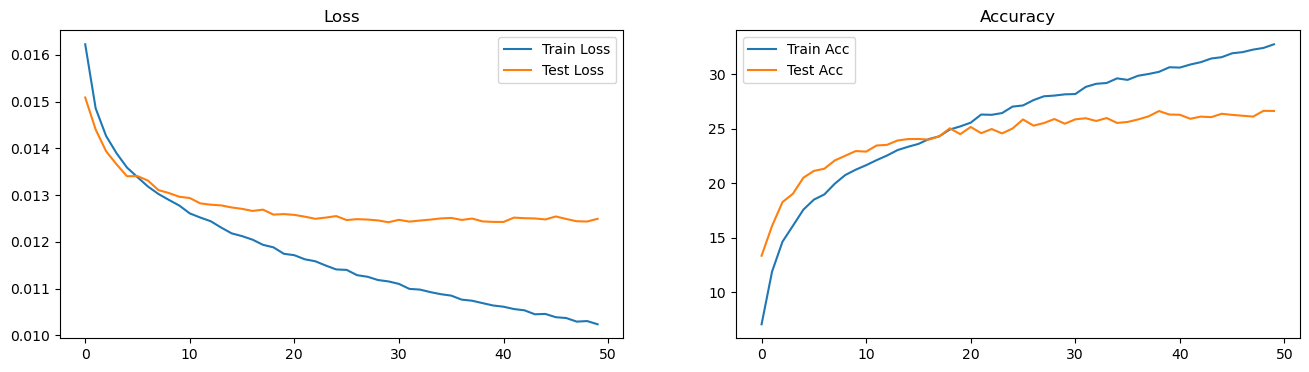

Best Metric
Train Loss: 0.0103, Train Acc: 32.4000
Test Loss: 0.0124, Test Acc: 26.6300


In [25]:
main('cifar100', 'adam', 'relu', 0.3)